# Anomaly Detection Algorithm using Gaussian Mixture Model

Name: **Jun Sung Park**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`.

In [1]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ae55b4c4e976d245d51cf443ebcd999c6d37fbe9ab36d8412212ee50fe4106a2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

## Part 1: EDA

In [5]:
### YOUR CODE HERE ###

# Number of Rows:

  # 284807
len(df)

284807

In [6]:
# What features in the dataset are present aside from the 28 main features?

  # Time, Amount, Class
  # But the column "Class" is the target column, containing only 0 or 1.
  # Therefore, there are 2 features (Time and Amount) aside from the 28 main ones.

print(len(df.columns))
print(df.columns)

31
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [7]:
# Which column contains the targets?:

  # "Class"

print("There are target values of :", df.loc[:,"Class"].unique())

df.loc[:,["Class"]].nunique()

There are target values of : [0 1]


Class    2
dtype: int64

In [8]:
# What is the meaning of target values?

# Since our main goal is find frauds, 1 True (is fraud) and 0 is False (not fraud)
# 0 means not fraud
# 1 means fruad

It's important to know how many examples we have for each class when we work with a new dataset.

* What is the percentage of entries in the dataset for each class?
  - percentage of class 0 is 99.827%  
  - percentage of class 1 is 0.1727%
* Is this data considered balanced or unbalanced? Why is this the case?
  - **This data is not considered balanced. The percentage of class "0" (Not fraud) is way more than the percentage of class "1" (Is Fraud). 99.83% of the data are not fruad, but only 0.17% are fraud.**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1?
  - Balance/imbalance of our data is extremely important especially in the anomaly detection problem. It is because we want to correctly determine the fraud transactions as much as possible, but if the dataset is only containing majority amount of valid (non-fraud) transactions, our prediction could have a high chance where we could classify a fraud transaction as a valid (non-fraud) transaction instead. Therefore, a special metric would have to be applied to deal with this imbalanced data set. For the current dataset we have, the 0 "class" is the majority. Therefore, according to the current class distribution, the KNN classfier will be biased towards the dominant class (which is 0), making the training process highly biased. This will eventually could result in inaccurate testing accuracy on KNN model.
* What metrics should we use to evaluate a model in such cases?
  - F1 Score can be implemented to evaluate a model in such case when the data is considered imbalanced.
  - F1 score computes the following:
    - F1 = (2 * Precision * Recall) / (Precision + Recall)
    - Where
      - Precision = TP / (TP + FP)
      - Recall = TP / (TP + FN)
      - TP = True Positive
      - FP = False Positive
      - FN = False Negative

  - From here, we can notice that F1 Score does not consider True Negative (TN), which will be the majority of our imbalanced data set.


In [9]:
# What is the percentage of entries in the dataset for each class?
num_entry0 = len(df.loc[:,["Class"]][df.Class == 0])
num_entry1 = len(df.loc[:,["Class"]][df.Class == 1])
num_both_class = len(df.loc[:,["Class"]])

print("percentage of class 0:", num_entry0/num_both_class)
print("percentage of class 1:", num_entry1/num_both_class)

percentage of class 0: 0.9982725143693799
percentage of class 1: 0.001727485630620034


In [10]:
# Is this data considered balanced or unbalanced? Why is this the case?

# Response:
# This data is not considered balanced. The percentage of class "0" (Not fraud) is way more
# than the percentage of class "1" (Is Fraud).
# 99.83% of the data are not fruad, but only 0.17% are fraud.

In [11]:
# Why is balance/imbalance important? How might this class ditribution affect a KNN classifier 
# for example, which we explored in Project 1?

# Response: 

# Balance/imbalance of our data is extremely important especially in the anomaly detection problem. 
# It is because we want to correctly determine the fraud transactions as much as possible, but if the dataset is only containing majority amount of valid (non-fraud)
# transactions, our prediction could have a high chance where we could classify a fraud transaction as a valid (non-fraud) transaction instead.
# Therefore, a special metric would have to be applied to deal with this imbalanced data set.

# For the current dataset we have, the 0 "class" is the majority. Therefore, according to the current class distribution, the KNN classfier will be biased towards 
# the dominant class (which is 0), making the training process highly biased. This will eventually could result in inaccurate testing accuracy on KNN model.

In [12]:
# What metrics should we use to evaluate a model in such cases 

# F1 Score can be implemented to evaluate a model in such case when the data is considered imbalanced.
# F1 score computes the following:
    # F1 = (2 * Precision * Recall) / (Precision + Recall)
    # Where
      # Precision = TP / (TP + FP)
      # Recall = TP / (TP + FN)
      # TP = True Positive
      # FP = False Positive
      # FN = False Negative

# From here, we can notice that F1 Score does not consider True Negative (TN), which will be the
# majority of our imbalanced data set.


Next, split the dataset into a training (65%), validation (20%) and testing set (15%). Set the random state to 40. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [13]:
# All features, excluding "Amount" and "Time",
X = df.iloc[:,1:29]
# Only the column "Class"
y = df["Class"]

In [14]:
### Split the data  ###

#X_train, X_val, X_test, y_train, y_val, y_test = 0, 0, 0, 0, 0, 0

# First, split into Train and Test sets. Only 15% will be the testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 40)

# Out of the remaining 85% of the data (Training and Validation combined), only 
# 65/(85) % will be the actual training set.
train_ratio = 65/(65+20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  train_size = train_ratio, random_state = 40) 

In [15]:
# Verifying train test split ratio
print("Training (65%):", len(X_train)/len(X))
print("Validation (20%):", len(X_val)/len(X))
print("Testing (15%):", len(X_test)/len(X))

Training (65%): 0.6499945577180336
Validation (20%): 0.20000210668979343
Testing (15%): 0.15000333559217294


Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

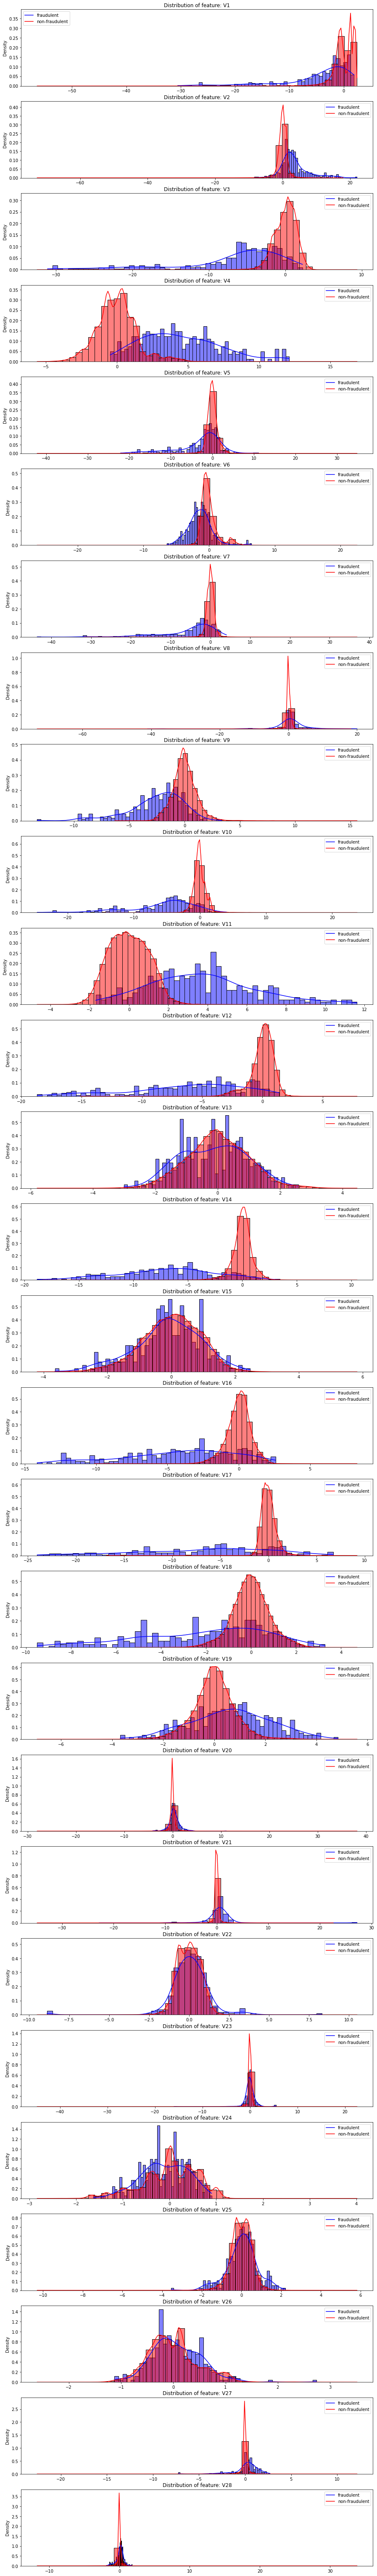

In [16]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model:

The plots above show the distribution of fraudulent and non-fraudulent data for each main feature (V1 to V28). They provide information whether each of the main feature can distinguish fraud data with non-fraud data. For example, features such as V14 and V17 show that the two target classes distinguished quite apparently. Those features will be more likely useful in the future process where we can select only certain data to train our anomaly detection model. Another example, V25 and V26 have fraudulent and non-fraudulent data overlapping distribution. They might not be too useful in the future to train our model.

## Part 2: One Gaussian model with Single feature:
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table.
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set.
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. 
  7. Report Precision, Recall and F1 score on both training and validation set in a table using the threshold you found in previous step. 
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.
    - In this part, I will assume that the question is asking for the complexity of determing 1 optimal threshold for a single feature (i.e. I will not consider it has finding thresholds for all 28 features). 
    - If my assumption is valid, there is one for loop being computed to run under my function called "analyze_scores2". This for loop takes the following argument : "for j in [1, 10, 20, 30, 100 , 120, 130]:"
    - here the value j is within a list of length 7, which means the for-loop will be looped 7 times. But because the numbers in the list are arbitrarly set, there could be even worser case when the list is 100 or 1000 long in length. Therefore the Big O notation will be O(n) to compute one threshold of a single feature.

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. repeat part 2a to compute AUC, F1 score, Precision and Recall when you fit a Gaussian **only on non-fraudulent transactions in the training set** in step 1 (instead of all the transactions).
 3. Compare your results from parts 2a and 2b in a table (for both training and validation set).
 4. Are these results different or similar? Why?
  - Response provided at the very last cell of Part 2


In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

### Part 2a

In [18]:
# Pick a random single feature. Let's say V3
# V3 data can be selected like:  X_train.iloc[:,[2]]

# Compute AUC on Full Training:

gm_part2a_1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )

gm_part2a_1.fit(X_train.iloc[:,[2]])
p_part2a_1 = gm_part2a_1.score_samples(X_train.iloc[:,[2]])

fpr_sc_part2a_1, tpr_sc_part2a_1, _ = roc_curve(y_train, -1 * p_part2a_1) # Labels: Valid=0, predictions: Valid =1 

auc_training_part2a_1 =  auc(fpr_sc_part2a_1, tpr_sc_part2a_1)
print("AUC on a single feature (V3) on Full Training Set", auc_training_part2a_1)

AUC on a single feature (V3) on Full Training Set 0.8700041652997159


In [19]:
# Compute AUC on Validation Set:

gm_part2a_2 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )

gm_part2a_2.fit(X_train.iloc[:,[2]])
p_part2a_2 = gm_part2a_2.score_samples(X_val.iloc[:,[2]])

fpr_sc_part2a_2, tpr_sc_part2a_2, _ = roc_curve(y_val, -1 * p_part2a_2) # Labels: Valid=0, predictions: Valid =1 

auc_training_part2a_2 =  auc(fpr_sc_part2a_2, tpr_sc_part2a_2)
print("AUC on a single feature (V3) on Validation Set", auc_training_part2a_2)

AUC on a single feature (V3) on Validation Set 0.8567589469836475


In [20]:
def auc_search(X_fit, X_train, y_train, X_val, y_val, num_features):

  features_and_auc = []

  for i in range(len(X_train.columns)):

    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm.fit(X_fit.iloc[:,[i]])
    p = gm.score_samples(X_train.iloc[:,[i]])
    p_val = gm.score_samples(X_val.iloc[:,[i]])

    fpr_sc, tpr_sc, _ = roc_curve(y_train, -1 * p) # Labels: Valid=0, predictions: Valid =1 
    fpr_sc_val, tpr_sc_val, _ = roc_curve(y_val, -1 * p_val)

    features_and_auc.append( (X_train.columns[i], auc(fpr_sc, tpr_sc), auc(fpr_sc_val, tpr_sc_val)) )

  auc_df = pd.DataFrame(features_and_auc, columns = ["Feature Name", "AUC (Training)", "AUC (Validation)"])
  auc_df['sort'] = auc_df['Feature Name'].str.extract('(\d+)', expand=False).astype(int)
  auc_df.sort_values('sort', inplace=True, ascending=True)
  auc_df = auc_df.drop('sort', axis=1)
  #auc_df = auc_df.set_index("num_feature").reset_index(drop = True)
  #auc_df.index = np.arange(1, len(auc_df)+1)

  return auc_df.head(num_features)

  # return auc_df #.sort_values(by="AUC", ascending = False).head(num_features)

In [21]:
auc_search(X_train, X_train, y_train, X_val, y_val, 28)

,Feature Name,AUC (Training),AUC (Validation)
0,V1,0.692540,0.716118
1,V2,0.848245,0.852456
2,V3,0.870004,0.856759
3,V4,0.889715,0.883280
4,V5,0.761153,0.781160
5,V6,0.727997,0.721413
6,V7,0.865497,0.887163
7,V8,0.774903,0.790317
8,V9,0.799279,0.794323
9,V10,0.910025,0.917279


In [22]:
# Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set.

# Function that returns top 3 validation auc:
def auc_search_top3_Validation(X_fit, X_train, y_train, X_val, y_val, num_features):

  features_and_auc = []

  for i in range(len(X_train.columns)):

    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm.fit(X_fit.iloc[:,[i]])
    p = gm.score_samples(X_train.iloc[:,[i]])
    p_val = gm.score_samples(X_val.iloc[:,[i]])

    fpr_sc, tpr_sc, _ = roc_curve(y_train, -1 * p) # Labels: Valid=0, predictions: Valid =1 
    fpr_sc_val, tpr_sc_val, _ = roc_curve(y_val, -1 * p_val)

    features_and_auc.append( (X_train.columns[i], auc(fpr_sc, tpr_sc), auc(fpr_sc_val, tpr_sc_val)) )

  auc_df = pd.DataFrame(features_and_auc, columns = ["Feature Name", "AUC (Training)", "AUC (Validation)"])
  auc_df['sort'] = auc_df['Feature Name'].str.extract('(\d+)', expand=False).astype(int)
  auc_df.sort_values('sort', inplace=True, ascending=True)
  auc_df = auc_df.drop('sort', axis=1)
  #auc_df = auc_df.set_index("num_feature").reset_index(drop = True)
  #auc_df.index = np.arange(1, len(auc_df)+1)

  return auc_df.sort_values(by="AUC (Validation)", ascending = False).head(num_features)

In [23]:
auc_top3_val = auc_search_top3_Validation(X_train, X_train, y_train, X_val, y_val, 3)
auc_top3_val

,Feature Name,AUC (Training),AUC (Validation)
13,V14,0.948014,0.955065
16,V17,0.928937,0.925698
9,V10,0.910025,0.917279


In [24]:
# V14, V17, and V10 are giving the top three AUC (Validation)

auc_top3_val[["Feature Name"]]

,Feature Name
13,V14
16,V17
9,V10


In [25]:
# Previous Method I used to find top 3. (This method is outdated, but only used because I have used the output from here to compute prediction)
def auc_search_top3(X_fit, X_set, y_set):

  features_and_auc = []

  for i in range(len(X_set.columns)):

    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm.fit(X_fit.iloc[:,[i]])
    p = gm.score_samples(X_set.iloc[:,[i]])

    fpr_sc, tpr_sc, _ = roc_curve(y_set, -1 * p) # Labels: Valid=0, predictions: Valid =1 

    features_and_auc.append( (i+1, auc(fpr_sc, tpr_sc)) )

  auc_df = pd.DataFrame(features_and_auc, columns = ["num_feature", "AUC"])
  auc_df = auc_df.set_index("num_feature").reset_index(drop = True)
  auc_df.index = np.arange(1, len(auc_df)+1)

  return auc_df.sort_values(by="AUC", ascending = False).head(3) # Return Top 3 AUC only with corresponding features

In [26]:
#  V14, V17, V10 are best features according to Validation Sets
val_set_top3 = auc_search_top3(X_train, X_val, y_val)
val_set_top3

,AUC
14,0.955065
17,0.925698
10,0.917279


In [27]:
val_top_features = val_set_top3.index
val_top_features

Int64Index([14, 17, 10], dtype='int64')

In [28]:
# Make a prediction based on a model's scores: If the score_samples is lower than a threshold, we consider that transaction as a fraud. 
# Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. 
# (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using sklearn.metrics.f1_score. [0.5]

# Report Precision, Recall and F1 score on both training and validation set in a table using the threshold you found in previous step.

# Report the complexity of your method (Big O notation) for determining the optimal threshold.[0.3]

In [29]:
# x_train_top3 = X_train.loc[:, ["V14", "V17", "V10"]]
# x_train_top3
x_train_top3 = X_train.iloc[:, val_top_features - 1]
x_train_top3.head()

,V14,V17,V10
205223,-0.396055,-0.318256,0.805711
105129,-0.114055,-0.056236,-0.108677
164416,-1.908750,1.289429,0.087001
22283,-0.722381,0.337883,-0.371767
68585,-0.507907,-0.335122,-1.092186


In [30]:
x_val_top3 = X_val.iloc[:, val_top_features - 1]

#### Finding Thresholds

In [31]:
def analyze_scores2(X_set_train, X_set_val, y_val):
  # Returns a data frame of corresponding thresholds, F1, Precision, and Recall for each Feature.
  scores_list = []

  for i in range(len(X_set_train.columns)):

    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm.fit(X_set_train.iloc[:,[i]])

    # p_train = gm.score_samples(X_set_train.iloc[:, [i]])
    p_val = gm.score_samples(X_set_val.iloc[:, [i]])

    for j in [1, 10, 20, 30, 100 , 120, 130]: 
      tr = sorted(p_val)[j] #We sort the points by probability
      precision = precision_score(y_val, p_val < tr) 
      recall = recall_score(y_val, p_val < tr) 
      f1 = f1_score(y_val, p_val <= tr)
      scores_list.append([X_set_train.columns[i], tr, f1, precision, recall])

  df_scores = pd.DataFrame(scores_list, columns = ["Feature Name", "Threshold", "F1", "Precision", "Recall"])

  return df_scores

In [32]:
testpa2 = analyze_scores2(x_train_top3, x_val_top3, y_val)

In [33]:
testpa2[testpa2["Feature Name"] == "V14" ].sort_values(by = "F1", ascending = False).head()

,Feature Name,Threshold,F1,Precision,Recall
4,V14,-17.814569,0.610837,0.610000,0.598039
5,V14,-15.316259,0.609865,0.558333,0.656863
6,V14,-14.087357,0.592275,0.530769,0.676471
3,V14,-43.812299,0.406015,0.866667,0.254902
2,V14,-58.118277,0.276423,0.800000,0.156863


In [34]:
# Threshold for V14: 
tr_v14 = testpa2[testpa2["Feature Name"] == "V14" ].sort_values(by = "F1", ascending = False).head(1)["Threshold"][4]
tr_v14

-17.814568936786415

In [35]:
testpa2[testpa2["Feature Name"] == "V17" ].sort_values(by = "F1", ascending = False).head()

,Feature Name,Threshold,F1,Precision,Recall
11,V17,-16.028962,0.571429,0.580000,0.568627
12,V17,-14.045103,0.565022,0.525000,0.617647
13,V17,-12.651528,0.557940,0.492308,0.627451
10,V17,-94.282165,0.421053,0.900000,0.264706
9,V17,-113.422779,0.292683,0.850000,0.166667


In [36]:
# Threshold for V17: 
tr_v17 = testpa2[testpa2["Feature Name"] == "V17" ].sort_values(by = "F1", ascending = False).head(1)["Threshold"][11]
tr_v17

-16.02896169440094

In [37]:
testpa2[testpa2["Feature Name"] == "V10" ].sort_values(by = "F1", ascending = False).head()

,Feature Name,Threshold,F1,Precision,Recall
18,V10,-30.140870,0.206897,0.200000,0.196078
19,V10,-27.188319,0.206278,0.191667,0.225490
20,V10,-25.724645,0.197425,0.176923,0.225490
17,V10,-53.760297,0.195489,0.433333,0.127451
16,V10,-62.139235,0.195122,0.600000,0.117647


In [38]:
# Threshold for V10: 
tr_v10 = testpa2[testpa2["Feature Name"] == "V10" ].sort_values(by = "F1", ascending = False).head(1)["Threshold"][18]
tr_v10

-30.1408696251909

In [39]:
def report_scores(X_set_train, X_set_val, y_train, y_val, n_comp, tr = [-20, -20, -30]):

  score_list = []

  for i in range(len(X_set_train.columns)):

    gm = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )
    gm.fit(X_set_train.iloc[:,[i]])

    p_train = gm.score_samples(X_set_train.iloc[:,[i]])
    p_val = gm.score_samples(X_set_val.iloc[:, [i]])

    precision_train = precision_score(y_train, p_train <= tr[i]) 
    recall_train = recall_score(y_train, p_train <= tr[i])
    f1_train = f1_score(y_train, p_train <= tr[i])

    precision_val = precision_score(y_val, p_val <= tr[i]) 
    recall_val = recall_score(y_val, p_val <= tr[i])
    f1_val = f1_score(y_val, p_val <= tr[i])

    score_list.append([X_set_train.columns[i], tr[i], precision_train, precision_val, recall_train, recall_val, f1_train, f1_val])

    print("On Training Set Feature", X_set_train.columns[i], 'For threshold of ',tr[i],' \t Precision: ', '%.3f' % precision_train,' Recall: ', '%.3f' % recall_train,' F1: ', '%.3f' % f1_train) 
    print("On Validation Set Feature", X_set_train.columns[i], 'For threshold of ',tr[i],' \t Precision: ', '%.3f' % precision_val,' Recall: ', '%.3f' % recall_val,' F1: ', '%.3f' % f1_val) 
  
  df_output = pd.DataFrame(score_list, columns = ["Feature Name", "Threshold", "Precision (Train)", "Precision (Val)", "Recall (Train)", "Recall (Val)", "F1 (Train)", "F1 (Val)"])

  return df_output

In [40]:
report_scores(x_train_top3, x_val_top3, y_train, y_val, 1, tr = [tr_v14, tr_v17, tr_v10])

On Training Set Feature V14 For threshold of  -17.814568936786415  	 Precision:  0.575  Recall:  0.593  F1:  0.584
On Validation Set Feature V14 For threshold of  -17.814568936786415  	 Precision:  0.614  Recall:  0.608  F1:  0.611
On Training Set Feature V17 For threshold of  -16.02896169440094  	 Precision:  0.566  Recall:  0.584  F1:  0.575
On Validation Set Feature V17 For threshold of  -16.02896169440094  	 Precision:  0.574  Recall:  0.569  F1:  0.571
On Training Set Feature V10 For threshold of  -30.1408696251909  	 Precision:  0.189  Recall:  0.217  F1:  0.202
On Validation Set Feature V10 For threshold of  -30.1408696251909  	 Precision:  0.208  Recall:  0.206  F1:  0.207


,Feature Name,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,V14,-17.814569,0.575301,0.613861,0.593168,0.607843,0.584098,0.610837
1,V17,-16.028962,0.566265,0.574257,0.583851,0.568627,0.574924,0.571429
2,V10,-30.140870,0.188679,0.207921,0.217391,0.205882,0.202020,0.206897


### Part 2b

In [41]:
# Part 2 b)


# Pick 3 features that had the best AUC in Part 2a.

# repeat part 2a to compute AUC, F1 score, Precision and Recall when you fit a Gaussian only on non-fraudulent transactions in the training 
# set in step 1 (instead of all the transactions).

# Compare your results from parts 2a and 2b in a table (for both training and validation set). [0.2]

# Are these results different or similar? Why?[0.5]

In [42]:
# From Part 2a), 3 features that had the best AUC are V14, V17, V10

val_top_features

Int64Index([14, 17, 10], dtype='int64')

In [43]:
# Filter and create new dataframes for non-fraudulent data only.

In [44]:
full_train_non_fraud = X_train.copy()
full_train_non_fraud["Class"] = y_train # Combine X and Y sets.
full_train_non_fraud = full_train_non_fraud[full_train_non_fraud["Class"] == 0] # Filtering only Class of 0
X_train_nf = full_train_non_fraud.iloc[:, :-1]  # Non-fraud X Training Set
y_train_nf = full_train_non_fraud.iloc[:,-1]  # Non-fraud y Training Set

In [45]:
full_val_non_fraud = X_val.copy()
full_val_non_fraud["Class"] = y_val
full_val_non_fraud = full_val_non_fraud[full_val_non_fraud["Class"] == 0] 
X_val_nf = full_val_non_fraud.iloc[:, :-1]  # Non-fraud X Val Set
y_val_nf = full_val_non_fraud.iloc[:,-1]  # Non-fraud y Val Set

In [46]:
X_train_nf_top3 = X_train_nf.iloc[:, val_top_features - 1]
X_val_nf_top3 = X_val_nf.iloc[:, val_top_features - 1]

In [47]:
def analyze_scores2(X_set_train, X_set_val, y_val):
  # Returns a data frame of corresponding thresholds, F1, Precision, and Recall for each Feature.
  scores_list = []

  for i in range(len(X_set_train.columns)):

    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm.fit(X_set_train.iloc[:,[i]])

    p_val = gm.score_samples(X_set_val.iloc[:, [i]])

    for j in [1, 10, 20, 30, 100 , 120, 130]: 
      tr = sorted(p_val)[j] #We sort the points by probability
      precision = precision_score(y_val, p_val < tr) 
      recall = recall_score(y_val, p_val < tr) 
      f1 = f1_score(y_val, p_val <= tr)
      scores_list.append([X_set_train.columns[i], tr, f1, precision, recall])

  df_scores = pd.DataFrame(scores_list, columns = ["Feature Name", "Threshold", "F1", "Precision", "Recall"])

  return df_scores

In [48]:
part_2b = analyze_scores2( X_train_nf_top3, x_val_top3, y_val)

In [49]:
part_2b[part_2b["Feature Name"] == "V14" ].sort_values(by = "F1", ascending = False)

,Feature Name,Threshold,F1,Precision,Recall
4,V14,-20.216080,0.610837,0.610000,0.598039
5,V14,-17.222237,0.609865,0.566667,0.666667
6,V14,-15.900016,0.592275,0.530769,0.676471
3,V14,-49.922488,0.406015,0.866667,0.254902
2,V14,-66.262652,0.276423,0.800000,0.156863
1,V14,-103.859993,0.141593,0.700000,0.068627
0,V14,-148.053143,0.038462,1.000000,0.009804


In [50]:
tr_v14_2b = part_2b[part_2b["Feature Name"] == "V14" ].sort_values(by = "F1", ascending = False).head(1)["Threshold"][4]
tr_v14_2b

-20.216080315416065

In [51]:
part_2b[part_2b["Feature Name"] == "V17" ].sort_values(by = "F1", ascending = False)

,Feature Name,Threshold,F1,Precision,Recall
11,V17,-19.940435,0.571429,0.580000,0.568627
12,V17,-17.427293,0.565022,0.525000,0.617647
13,V17,-15.662202,0.557940,0.492308,0.627451
10,V17,-119.637643,0.421053,0.900000,0.264706
9,V17,-143.967158,0.292683,0.850000,0.166667
8,V17,-291.001700,0.194690,1.000000,0.098039
7,V17,-411.282364,0.038462,1.000000,0.009804


In [52]:
tr_v17_2b = part_2b[part_2b["Feature Name"] == "V17" ].sort_values(by = "F1", ascending = False).head(1)["Threshold"][11]
tr_v17_2b

-19.940435104725083

In [53]:
part_2b[part_2b["Feature Name"] == "V10" ].sort_values(by = "F1", ascending = False)

,Feature Name,Threshold,F1,Precision,Recall
18,V10,-32.743595,0.206897,0.200000,0.196078
19,V10,-29.385336,0.206278,0.191667,0.225490
20,V10,-27.794528,0.197425,0.176923,0.225490
17,V10,-58.364753,0.195489,0.433333,0.127451
16,V10,-67.382585,0.195122,0.600000,0.117647
15,V10,-76.209957,0.159292,0.900000,0.088235
14,V10,-122.343021,0.038462,1.000000,0.009804


In [54]:
tr_v10_2b = part_2b[part_2b["Feature Name"] == "V10" ].sort_values(by = "F1", ascending = False).head(1)["Threshold"][18]
tr_v10_2b

-32.743594642042865

In [55]:
def report_scores_2b(X_set_train_entire, X_set_train, X_set_val, y_train, y_val, n_comp, tr = [-20, -20, -30]):

  score_list = []

  for i in range(len(X_set_train.columns)):

    gm = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )
    gm.fit(X_set_train.iloc[:,[i]])

    p_train = gm.score_samples(X_set_train_entire.iloc[:,[i]])
    p_val = gm.score_samples(X_set_val.iloc[:, [i]])

    precision_train = precision_score(y_train, p_train <= tr[i]) 
    recall_train = recall_score(y_train, p_train <= tr[i])
    f1_train = f1_score(y_train, p_train <= tr[i])

    precision_val = precision_score(y_val, p_val <= tr[i]) 
    recall_val = recall_score(y_val, p_val <= tr[i])
    f1_val = f1_score(y_val, p_val <= tr[i])

    score_list.append([X_set_train.columns[i], tr[i], precision_train, precision_val, recall_train, recall_val, f1_train, f1_val])

    print("On Training Set Feature", X_set_train.columns[i], 'For threshold of ',tr[i],' \t Precision: ', '%.3f' % precision_train,' Recall: ', '%.3f' % recall_train,' F1: ', '%.3f' % f1_train) 
    print("On Validation Set Feature", X_set_train.columns[i], 'For threshold of ',tr[i],' \t Precision: ', '%.3f' % precision_val,' Recall: ', '%.3f' % recall_val,' F1: ', '%.3f' % f1_val) 
  
  df_output = pd.DataFrame(score_list, columns = ["Feature Name", "Threshold", "Precision (Train)", "Precision (Val)", "Recall (Train)", "Recall (Val)", "F1 (Train)", "F1 (Val)"])

  return df_output

In [56]:
# Part 2b - Final Table:
final_table_part_2b = report_scores_2b(x_train_top3, X_train_nf_top3, x_val_top3, y_train, y_val, 1, tr = [tr_v14_2b, tr_v17_2b, tr_v10_2b])
final_table_part_2b

On Training Set Feature V14 For threshold of  -20.216080315416065  	 Precision:  0.577  Recall:  0.593  F1:  0.585
On Validation Set Feature V14 For threshold of  -20.216080315416065  	 Precision:  0.614  Recall:  0.608  F1:  0.611
On Training Set Feature V17 For threshold of  -19.940435104725083  	 Precision:  0.568  Recall:  0.587  F1:  0.577
On Validation Set Feature V17 For threshold of  -19.940435104725083  	 Precision:  0.574  Recall:  0.569  F1:  0.571
On Training Set Feature V10 For threshold of  -32.743594642042865  	 Precision:  0.189  Recall:  0.217  F1:  0.202
On Validation Set Feature V10 For threshold of  -32.743594642042865  	 Precision:  0.208  Recall:  0.206  F1:  0.207


,Feature Name,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,V14,-20.216080,0.577039,0.613861,0.593168,0.607843,0.584992,0.610837
1,V17,-19.940435,0.567568,0.574257,0.586957,0.568627,0.577099,0.571429
2,V10,-32.743595,0.189189,0.207921,0.217391,0.205882,0.202312,0.206897


In [57]:
# Part 2a - Final Table:
final_table_part_2a = report_scores(x_train_top3, x_val_top3, y_train, y_val, 1, tr = [tr_v14, tr_v17, tr_v10])
final_table_part_2a

On Training Set Feature V14 For threshold of  -17.814568936786415  	 Precision:  0.575  Recall:  0.593  F1:  0.584
On Validation Set Feature V14 For threshold of  -17.814568936786415  	 Precision:  0.614  Recall:  0.608  F1:  0.611
On Training Set Feature V17 For threshold of  -16.02896169440094  	 Precision:  0.566  Recall:  0.584  F1:  0.575
On Validation Set Feature V17 For threshold of  -16.02896169440094  	 Precision:  0.574  Recall:  0.569  F1:  0.571
On Training Set Feature V10 For threshold of  -30.1408696251909  	 Precision:  0.189  Recall:  0.217  F1:  0.202
On Validation Set Feature V10 For threshold of  -30.1408696251909  	 Precision:  0.208  Recall:  0.206  F1:  0.207


,Feature Name,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,V14,-17.814569,0.575301,0.613861,0.593168,0.607843,0.584098,0.610837
1,V17,-16.028962,0.566265,0.574257,0.583851,0.568627,0.574924,0.571429
2,V10,-30.140870,0.188679,0.207921,0.217391,0.205882,0.202020,0.206897


In [58]:
# The results are very similar. Although the thresholds computed for each feature are different slightly, the F1, Recall, 
# and Precision of both Train and Validation sets are very close to each other for part 2a and part 2b.
# I believe this is the case because since the non-fraudulent data are already dominating the mojority of our dataset, fitting
# a Gaussian to only on non-fraud transactions didn't really resulted in huge difference.
# Note that close to 99.827% were found to be non-fraudulent data in the original data.
# Therefore, even if only the non-fraudulent data were fitted, the difference is very minute to fitting on entire data.

## **Part 3: One Gaussian model with multiple features: [2 Marks]**
This part is similar to Part 2, but here we will pick multiple features and set the number of components **visually**.

 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features of the training set on a figure (f1 on the x-axis and f2 on the y-axis). **[0.25]**
 3. On the scatter plot color the training set based on their class (non-fraudulents blue and fraudulents red). **[0.25]**
 4. Based on your plots decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). **[0.25]**
 5. Fit your Gaussian model on the training set (all samples). 
 6. Compute AUC on both training and validation sets **[0.25]**
 7. Pick 3 new pair of features and repeat steps 2 to 6. **[0.5]**
 8. Pick the set with the highest AUC on the validation set (out of the four sets that you tried.)
 9. Find a threshold to maximize your F1 Score on the validation set.**[0.25]**
 10. Plot two seperate figures (one for the training data and one for the validation data) similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in tutorial) **[0.25]**




In [59]:
# Pick V2 and V4 randomly for two features I want to test.

In [60]:
full_train = X_train.copy()
full_train["Class"] = y_train
train_fraud = full_train[full_train["Class"] == 1]
train_nfraud = full_train[full_train["Class"] == 0]

In [61]:
# From the below plot, I believe 2 components will be sufficient.

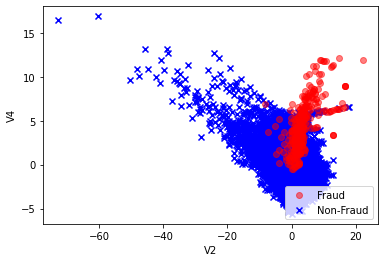

In [62]:
plot_non_fraud_only = plt.scatter(train_nfraud[["V2"]], train_nfraud["V4"], c = "blue", marker="x", alpha = 1)
plot_fraud_only = plt.scatter(train_fraud[["V2"]], train_fraud["V4"], c = "red", marker="o", alpha = 0.5)

#plt.scatter(full_train.loc[:,["V16"]], full_train.loc[:,["V18"]], marker="x", c = full_train[:,["Class"]])
plt.xlabel('V2')
plt.ylabel('V4')

plt.legend( (plot_fraud_only, plot_non_fraud_only), ("Fraud", "Non-Fraud"), loc = "lower right")
plt.show()

In [63]:
# Pick n_component = 2

In [64]:
part3_two_features_X_train = X_train.loc[:,["V2", "V4"]]
part3_two_features_X_val = X_val.loc[:,["V2", "V4"]]

In [65]:
def auc_search_part3_two_features(X_set, y_set, X_val, y_val, num_comp):

  # Input Training sets (X_set and y_set) and Validation sets (X_val and y_val)
  # Input Number of components (num_comp)
  # Return AUC Table

  features_and_auc = []

  gm = GaussianMixture(n_components = num_comp, covariance_type = 'full', random_state=0, )
  gm.fit(X_set)
  p = gm.score_samples(X_set)
  p_val = gm.score_samples(X_val)

  # gm.fit(X_set.iloc[:,[i]])
  # p = gm.score_samples(X_set.iloc[:,[i]])
  # p_val = gm.score_samples(X_val.iloc[:,[i]])

  fpr_t, tpr_t, _ = roc_curve(y_set, -1 * p) # Labels: Valid=0, predictions: Valid =1 
  fpr_v, tpr_v, _ = roc_curve(y_val, -1 * p_val)

  features_and_auc.append( ( auc(fpr_t, tpr_t), auc(fpr_v, tpr_v) ) )

  auc_df = pd.DataFrame(features_and_auc, columns = ["AUC Train Set", "AUC Validation Set"])

  return auc_df

In [66]:
auc_search_part3_two_features(part3_two_features_X_train, y_train, part3_two_features_X_val, y_val, 2)

,AUC Train Set,AUC Validation Set
0,0.90211,0.890482


In [67]:
# auc_search_part3_two_features(part3_two_features_X_train, y_train, part3_two_features_X_val, y_val, 2)

In [68]:
# Now I pick 3 new pairs of features randomly and repeat the above processes.

# I will pick:

  # V5, V6
  # V11, V12
  # V18, V19

part3_two_features_X_train2 = X_train.loc[:,["V5", "V6"]]
part3_two_features_X_val2 = X_val.loc[:,["V5", "V6"]]

part3_two_features_X_train3 = X_train.loc[:,["V11", "V12"]]
part3_two_features_X_val3 = X_val.loc[:,["V11", "V12"]]

part3_two_features_X_train4 = X_train.loc[:,["V18", "V19"]]
part3_two_features_X_val4 = X_val.loc[:,["V18", "V19"]]

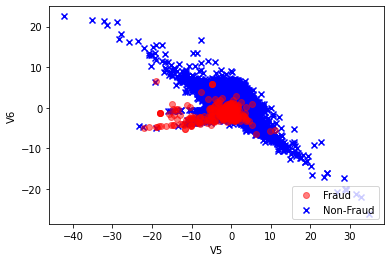

In [69]:
# V5, V6
plot_non_fraud_only = plt.scatter(train_nfraud[["V5"]], train_nfraud["V6"], c = "blue", marker="x", alpha = 1)
plot_fraud_only = plt.scatter(train_fraud[["V5"]], train_fraud["V6"], c = "red", marker="o", alpha = 0.5)

plt.xlabel('V5')
plt.ylabel('V6')

plt.legend( (plot_fraud_only, plot_non_fraud_only), ("Fraud", "Non-Fraud"), loc = "lower right")
plt.show()

In [70]:
# Pick n_component = 2

In [71]:
auc_search_part3_two_features(part3_two_features_X_train2, y_train, part3_two_features_X_val2, y_val, 2)

,AUC Train Set,AUC Validation Set
0,0.810698,0.811507


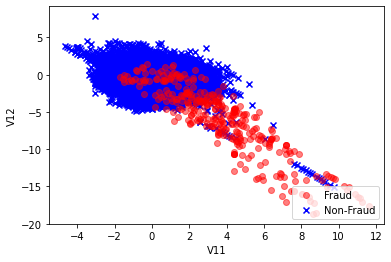

In [72]:
# V11, V12
plot_non_fraud_only = plt.scatter(train_nfraud[["V11"]], train_nfraud["V12"], c = "blue", marker="x", alpha = 1)
plot_fraud_only = plt.scatter(train_fraud[["V11"]], train_fraud["V12"], c = "red", marker="o", alpha = 0.5)

plt.xlabel('V11')
plt.ylabel('V12')

plt.legend( (plot_fraud_only, plot_non_fraud_only), ("Fraud", "Non-Fraud"), loc = "lower right")
plt.show()

In [73]:
# Pick n_component = 3

In [74]:
auc_search_part3_two_features(part3_two_features_X_train3, y_train, part3_two_features_X_val3, y_val, 3)

,AUC Train Set,AUC Validation Set
0,0.93568,0.913844


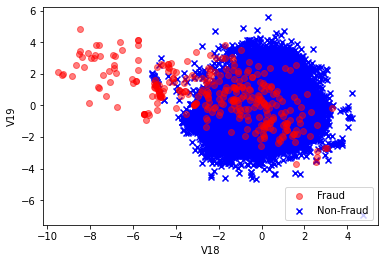

In [75]:
# V18, V19
plot_non_fraud_only = plt.scatter(train_nfraud[["V18"]], train_nfraud["V19"], c = "blue", marker="x", alpha = 1)
plot_fraud_only = plt.scatter(train_fraud[["V18"]], train_fraud["V19"], c = "red", marker="o", alpha = 0.5)

plt.xlabel('V18')
plt.ylabel('V19')

plt.legend( (plot_fraud_only, plot_non_fraud_only), ("Fraud", "Non-Fraud"), loc = "lower right")
plt.show()

In [76]:
# Pick n_component = 3

In [77]:
auc_search_part3_two_features(part3_two_features_X_train4, y_train, part3_two_features_X_val4, y_val, 3)

,AUC Train Set,AUC Validation Set
0,0.86802,0.827928


In [78]:
# Pick the set with the highest AUC on the Validation Set:

  # V11, V12

part3_highest = auc_search_part3_two_features(part3_two_features_X_train3, y_train, part3_two_features_X_val3, y_val, 3)
part3_highest

,AUC Train Set,AUC Validation Set
0,0.93568,0.913844


In [79]:
# Find a threshold to maximize your F1 Score on the validation set.

def analyze_scores2_part3(X_set_train, X_set_val, y_val, num_comp):
  # Returns a data frame of corresponding thresholds, F1, Precision, and Recall for each Feature.
  scores_list = []

  gm = GaussianMixture(n_components = num_comp, covariance_type = 'full', random_state=0, )
  gm.fit(X_set_train)

  p_val = gm.score_samples(X_set_val)

  for j in [1, 10, 20, 30, 100 , 120, 130]: 
    tr = sorted(p_val)[j] #We sort the points by probability
    precision = precision_score(y_val, p_val < tr) 
    recall = recall_score(y_val, p_val < tr) 
    f1 = f1_score(y_val, p_val <= tr)
    scores_list.append([tr, f1, precision, recall])

  df_scores = pd.DataFrame(scores_list, columns = ["Threshold", "F1", "Precision", "Recall"])

  return df_scores

In [80]:
p3_df = analyze_scores2_part3(part3_two_features_X_train3, part3_two_features_X_val3, y_val, 3)
p3_df.sort_values(by = "F1", ascending = False)

,Threshold,F1,Precision,Recall
4,-9.398470,0.482759,0.490000,0.480392
5,-8.925036,0.466368,0.433333,0.509804
6,-8.656769,0.446352,0.400000,0.509804
3,-13.963506,0.406015,0.866667,0.254902
2,-23.033554,0.292683,0.850000,0.166667
1,-33.942903,0.141593,0.700000,0.068627
0,-65.364918,0.038462,1.000000,0.009804


In [81]:
# Best Threshold: 
tr_p3 = p3_df.sort_values(by = "F1", ascending = False).head(1)["Threshold"][4]
tr_p3

-9.398470120659063

In [82]:
# Plot two seperate figures (one for the training data and one for the validation data) similar to step 3 and put 
# a circle around outliers based on your threshold (use the code of the similar figure in tutorial)

def part3_final_plot(X_train, X_val, tr, n_comp):
  gm = GaussianMixture(n_components = n_comp,
                    covariance_type = 'full', random_state=0, )
  gm.fit(X_train)

  plt.figure(figsize=(10,10))
  c = gm.score_samples(X_val)
  plt.scatter(X_val.iloc[:, 0], X_val.iloc[:, 1], c=gm.score_samples(X_val), cmap='viridis', marker='x')

  threshold = tr

  outliers = np.nonzero(c < threshold)[0]
  plt.scatter(X_val.iloc[outliers, 0], X_val.iloc[outliers, 1], marker = "o", facecolor = "none", edgecolor = "r", s = 70)
  plt.show()

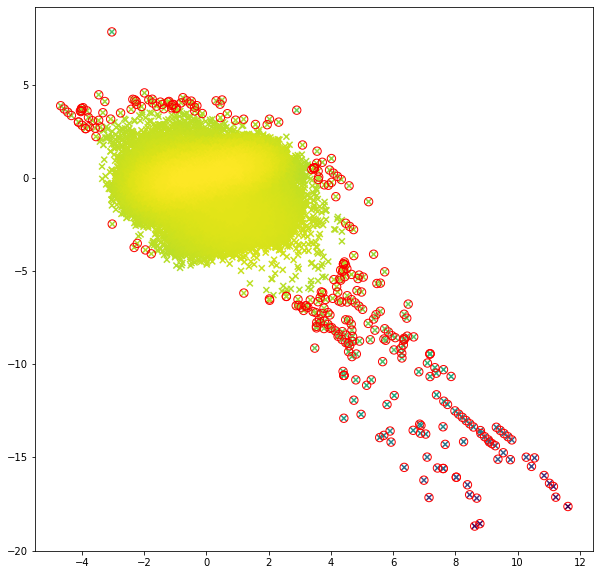

In [83]:
# Training Data:
part3_final_plot(part3_two_features_X_train3, part3_two_features_X_train3, tr_p3, 3)

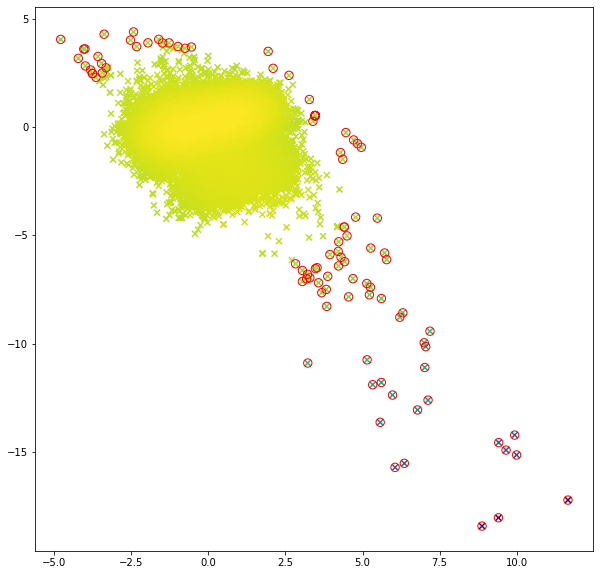

In [84]:
# Validation Data
part3_final_plot(part3_two_features_X_train3, part3_two_features_X_val3, tr_p3, 3)

## **Part 4:  Two Gaussian model with single feature. 
Now we will use two separate distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. 
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. 
  5. Repeat the steps above for all the features. What is the best F1 Score, Precision and Recall that you get for training and validation? Which feature and what c? Show your results in a table. 
  6. Can we report AUC for this model? Why? 
    - AUC for this model cannot be reported. AUC can be computed by auc(fpr, tpr) where fpr is False Positive Rate (Fallout) and TPR is True Positive Rate (Recall). FPR and TPR can be computed by from a ROC curve which can be found by roc_curve(y_val, -1 * p). In Part 4, we use two score samples, S1 and S2, to compute optimal threshold for the model. roc_curve, however, takes one score samples (probability distribution "p"), which makes it difficult for us to comput FPR and TPR based on ROC curve. In other words, because we have two Gaussian models, the AUC cannot be computed as we have already done in Part 2 and 3, where only one Gaussian model was implemented.

In [85]:
# The 4 cells below are just creating filtered Dataset that could be used in the future.

In [86]:
# Full Non-Fraud Training Set:
full_train_non_fraud = X_train.copy()
full_train_non_fraud["Class"] = y_train # Combine X and Y sets.
full_train_non_fraud = full_train_non_fraud[full_train_non_fraud["Class"] == 0] # Filtering only Class of 0
X_train_nf = full_train_non_fraud.iloc[:, :-1]  # Non-fraud X Training Set
y_train_nf = full_train_non_fraud.iloc[:,-1]  # Non-fraud y Training Set

In [87]:
# Full Non-Fraud Validation Set
full_val_non_fraud = X_val.copy()
full_val_non_fraud["Class"] = y_val
full_val_non_fraud = full_val_non_fraud[full_val_non_fraud["Class"] == 0] 
X_val_nf = full_val_non_fraud.iloc[:, :-1]  # Non-fraud X Val Set
y_val_nf = full_val_non_fraud.iloc[:,-1]  # Non-fraud y Val Set

In [88]:
# Full Fraud Training set:
full_train_fraud = X_train.copy()
full_train_fraud["Class"] = y_train # Combine X and Y sets.
full_train_fraud = full_train_fraud[full_train_fraud["Class"] == 1] # Filtering only Class of 1
X_train_f = full_train_fraud.iloc[:, :-1]  # Fraud X Training Set
y_train_f = full_train_fraud.iloc[:,-1]  # Fraud y Training Set

In [89]:
# Full Fraud Validation Set:
full_val_fraud = X_val.copy()
full_val_fraud["Class"] = y_train # Combine X and Y sets.
full_val_fraud = full_val_fraud[full_val_fraud["Class"] == 1] # Filtering only Class of 1
X_val_f = full_val_fraud.iloc[:, :-1]  # Fraud X Val Set
y_val_f = full_val_fraud.iloc[:,-1]  # Fraud y Val Set

In [90]:
# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions using sklearn.mixture.GaussianMixture when n_components=1

# I am going to pick the feature V14 to approach this problem as V14 resulted in the highest AUC from Part 2A

gm_g1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
gm_g1.fit(X_train_nf.loc[:, ["V14"]])

GaussianMixture(random_state=0)

In [91]:
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions using sklearn.mixture.GaussianMixture when n_components=1

gm_g2 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
gm_g2.fit(X_train_f.loc[:, ["V14"]])

GaussianMixture(random_state=0)

In [92]:
# Compute the score samples ( S ) for both  G1  and  G2  on the validation set to get  S1  and  S2 , respectively.

p_g1 = gm_g1.score_samples(X_val.loc[:, ["V14"]]) # S1
p_g2 = gm_g2.score_samples(X_val.loc[:, ["V14"]]) # S2

In [93]:
c = np.linspace(0, 10, 101)
c

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [94]:
# if S1 < (c * S2), then it is classified fraud.

c = np.linspace(0, 10, 101)
part4_step4_list = []

for i in c:
  # f1_val_part4_step4 = f1_score(y_val, p_g1 < (c[i]*p_g2) )
  f1_val_part4_step4 = f1_score(y_val, p_g1 < (i*p_g2) )
  part4_step4_list.append([i, f1_val_part4_step4])

df_c_list = pd.DataFrame(part4_step4_list, columns = ["c", "F1"])
df_c_list.sort_values(by="F1", ascending = False).reset_index(drop=True)

,c,F1
0,7.0,0.660194
1,6.9,0.657005
2,9.1,0.655914
3,6.5,0.654028
4,6.8,0.653846
...,...,...
96,0.4,0.017709
97,0.3,0.010187
98,0.2,0.003575
99,0.1,0.003575


In [95]:
# The Optimal c is found to be for Feature V14:

df_c_list.sort_values(by="F1", ascending = False).head(1)["c"][70] 

7.0

In [96]:
df_c_list.sort_values(by="F1", ascending = False).head(1)

,c,F1
70,7.0,0.660194


In [97]:
def find_optimal_c(X_train_nf, X_train_f, X_val, y_val):

  c_list1 = np.linspace(0, 10, 101) # c between 0 and 10. Step size = 0.1

  list_val1 = []
  df_output1 = pd.DataFrame()

  gm_g11 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  gm_g22 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )

  for i in range(len(X_train_nf.columns)):

    # Initialize for every feature
    df_c_list1 = pd.DataFrame()
    # df_train1 = pd.DataFrame()
    opt_c = 0
    list_val1 = []
    # list_train1 = []

    gm_g11.fit(X_train_nf.iloc[:, [i]])
    gm_g22.fit(X_train_f.iloc[:, [i]])

    p_g11 = gm_g11.score_samples(X_val.iloc[:, [i]]) # S1
    p_g22 = gm_g22.score_samples(X_val.iloc[:, [i]]) # S2

    # p_g11_t = gm_g11.score_samples(X_train.iloc[:, [i]])
    # p_g22_t = gm_g22.score_samples(X_train.iloc[:, [i]])

    # Loop to compute all possible c values.
    for c in c_list1:

      f1_val1 = f1_score(y_val, p_g11 < (c*p_g22) )
      list_val1.append([ X_train_nf.columns[i], c, f1_val1])

    df_c_list1 = pd.DataFrame(list_val1, columns = ["Feature Name", "c", "F1 (Validation)"])
    df_c_list1 = df_c_list1.sort_values(by="F1 (Validation)", ascending = False).head(1) # return 1 top row only
    opt_c = df_c_list1.sort_values(by="F1 (Validation)", ascending = False).reset_index(drop=True).head(1)["c"][0]
    
    precision_val1 = precision_score(y_val, p_g11 < (opt_c*p_g22)) 
    recall_val1 = recall_score(y_val, p_g11 < (opt_c*p_g22)) 
    df_c_list1["Precision (Validation)"] = precision_val1
    df_c_list1["Recall (Validation)"] = recall_val1

    df_output1 = pd.concat([df_output1, df_c_list1], axis = 0)

  return df_output1


In [98]:
optimal_c = find_optimal_c(X_train_nf, X_train_f, X_val, y_val)
optimal_c = optimal_c.reset_index(drop = True)
optimal_c

,Feature Name,c,F1 (Validation),Precision (Validation),Recall (Validation)
0,V1,6.6,0.152381,0.148148,0.156863
1,V2,5.9,0.175439,0.833333,0.098039
2,V3,7.6,0.312139,0.380282,0.264706
3,V4,4.2,0.377358,0.363636,0.392157
4,V5,8.3,0.193939,0.253968,0.156863
5,V6,1.9,0.118812,0.079470,0.235294
6,V7,10.0,0.237113,0.250000,0.225490
7,V8,6.9,0.104167,0.080645,0.147059
8,V9,3.4,0.448980,0.733333,0.323529
9,V10,6.8,0.397590,0.515625,0.323529


In [99]:
opt_c_final = optimal_c["c"].reset_index(drop=True)

In [100]:
def part4_trainingset(X_train_nf, X_train_f, X_train, y_train, opt_c):

  df_final = pd.DataFrame()

  for i in range(len(X_train_nf.columns)):
    list_train1 = []
    df_train1 = pd.DataFrame()

    gm_g11 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm_g22 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )

    gm_g11.fit(X_train_nf.iloc[:, [i]])
    gm_g22.fit(X_train_f.iloc[:, [i]])

    p_g11_t = gm_g11.score_samples(X_train.iloc[:, [i]])
    p_g22_t = gm_g22.score_samples(X_train.iloc[:, [i]])

    # Using the optimal_c, Compute f1, precision, and recall on Training set as well.
    f1_training = f1_score(y_train, p_g11_t < (opt_c[i] * p_g22_t) )
    precision_training = precision_score(y_train, p_g11_t < (opt_c[i] * p_g22_t)) 
    recall_training = recall_score(y_train, p_g11_t < (opt_c[i] * p_g22_t))

    # Append it to list_train1
    list_train1.append([X_train_nf.columns[i] , f1_training, precision_training, recall_training])
    # Convert list_train1 to DF
    df_train1 = pd.DataFrame(list_train1, columns = ["Feature Name", "F1 (train)", "Precision (train)", "Recall (train)"]) 

    df_final = pd.concat([df_final, df_train1], axis = 0)

  return df_final


In [101]:
part4_training_table = part4_trainingset(X_train_nf, X_train_f, X_train, y_train, opt_c_final)

In [102]:
part4_training_table = part4_training_table.reset_index(drop=True)
part4_training_table

,Feature Name,F1 (train),Precision (train),Recall (train)
0,V1,0.128440,0.126506,0.130435
1,V2,0.127778,0.605263,0.071429
2,V3,0.268714,0.351759,0.217391
3,V4,0.355958,0.346041,0.366460
4,V5,0.164706,0.223404,0.130435
5,V6,0.100000,0.067164,0.195652
6,V7,0.245378,0.267399,0.226708
7,V8,0.063694,0.048387,0.093168
8,V9,0.406321,0.743802,0.279503
9,V10,0.383803,0.443089,0.338509


In [103]:
part4_final_df = optimal_c.merge(part4_training_table, on = "Feature Name")
part4_final_df

,Feature Name,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,V1,6.6,0.152381,0.148148,0.156863,0.128440,0.126506,0.130435
1,V2,5.9,0.175439,0.833333,0.098039,0.127778,0.605263,0.071429
2,V3,7.6,0.312139,0.380282,0.264706,0.268714,0.351759,0.217391
3,V4,4.2,0.377358,0.363636,0.392157,0.355958,0.346041,0.366460
4,V5,8.3,0.193939,0.253968,0.156863,0.164706,0.223404,0.130435
5,V6,1.9,0.118812,0.079470,0.235294,0.100000,0.067164,0.195652
6,V7,10.0,0.237113,0.250000,0.225490,0.245378,0.267399,0.226708
7,V8,6.9,0.104167,0.080645,0.147059,0.063694,0.048387,0.093168
8,V9,3.4,0.448980,0.733333,0.323529,0.406321,0.743802,0.279503
9,V10,6.8,0.397590,0.515625,0.323529,0.383803,0.443089,0.338509


In [234]:
# For each feature, the optimal c value is determined. Based on the optimal c for each feature, the F1 Score, Precision, and Recall are calculated on
# both the validation and training data sets, as shown above in the dataframe part4_final_df. 

# In terms of the highest F1 Score on Validation Set, feature V17 resulted the highest with 0.670157. The corresponding C value is 5.9
# In terms of the highest F1 Score on Training Set, feature V12 resulted the highest with 0.673540. The corresponding C value is 4.4

# In terms of the highest Precision on Validation Set, feature V18 resulted the highest with 0.885714	. The corresponding C value is 5.1
# In terms of the highest Precision on Training Set, feature V16 resulted the highest with 0.770053. The corresponding C value is 5.2

# In terms of the highest Recall on Validation Set, feature V14 resulted the highest with 0.666667. The corresponding C value is 7.0
# In terms of the highest Recall on Training Set, feature V14 resulted the highest with 0.639752. The corresponding C value is 7.0

In [233]:
# Can we report AUC for this model? Why?
 
# Response provided above in text cell.


## Part 5: Multivariate and Mixture of Gaussians Distribution 
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) .
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score, Precision and Recall (after tuning the threshold) for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. 


**HINT !**

You might want to try a two gaussian model, multiple features, single component for valid transaction and multiple components for fraudulent ones! Why does it make sense to have multiple components for the fraudulent transactions?

### Part 5 - Model 1

In [106]:
# First Model:

# One Gaussian model with single feature
# Use top 8 features with highest AUC computed on Validation sets
# n_components = 1

def auc_search_top_n(X_fit, X_set, y_set, n):
  # Return dataframe of Top n Features in terms of AUC

  features_and_auc = []

  for i in range(len(X_set.columns)):

    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
    gm.fit(X_fit.iloc[:,[i]])
    p = gm.score_samples(X_set.iloc[:,[i]])

    fpr_sc, tpr_sc, _ = roc_curve(y_set, -1 * p) # Labels: Valid=0, predictions: Valid =1 

    features_and_auc.append( (i+1, auc(fpr_sc, tpr_sc)) )

  auc_df = pd.DataFrame(features_and_auc, columns = ["num_feature", "AUC"])
  auc_df = auc_df.set_index("num_feature").reset_index(drop = True)
  auc_df.index = np.arange(1, len(auc_df)+1)

  return auc_df.sort_values(by="AUC", ascending = False).head(n) # Return Top n AUC only with corresponding features

In [107]:
top8 = auc_search_top_n(X_train, X_val, y_val, 8)

In [108]:
# AUC for each Feature is computed.
# AUC for V14 is the highest, having AUC of 0.955065

top8

,AUC
14,0.955065
17,0.925698
10,0.917279
16,0.896325
12,0.892862
7,0.887163
4,0.883280
11,0.880086


In [109]:
# Find Top8 Features Indices, and sort them in order.
model1_top_features = [i for i in top8.index]
model1_top_features = sorted(model1_top_features)
model1_top_features = np.array(model1_top_features)
model1_top_features

array([ 4,  7, 10, 11, 12, 14, 16, 17])

In [110]:
# Create filterd X_train and X_val only containing the top 10 features.
X_train_top8 = X_train.iloc[:, model1_top_features - 1]
X_val_top8 = X_val.iloc[:, model1_top_features - 1]

In [111]:
# Function from Part 2a) ==> returns dataframe of thresholds
model1_threshold_df = analyze_scores2(X_train_top8, X_val_top8, y_val)
model1_threshold_df

# Maximum F1 for each feature
grouped_feature10 = model1_threshold_df.groupby('Feature Name')[["F1"]].max().reset_index()
grouped_feature10

,Feature Name,F1
0,V10,0.206897
1,V11,0.532020
2,V12,0.600985
3,V14,0.610837
4,V16,0.463054
5,V17,0.571429
6,V4,0.367713
7,V7,0.216749


In [112]:
grouped_feature10['sort'] = grouped_feature10['Feature Name'].str.extract('(\d+)', expand=False).astype(int)
grouped_feature10.sort_values('sort', inplace=True, ascending=True)
grouped_feature10 = grouped_feature10.drop('sort', axis=1)
grouped_feature10

,Feature Name,F1
6,V4,0.367713
7,V7,0.216749
0,V10,0.206897
1,V11,0.532020
2,V12,0.600985
3,V14,0.610837
4,V16,0.463054
5,V17,0.571429


In [113]:
# Join two tables together on maximum F1 score for each feature. Therefore, the Thresholds that are giving the maximum F1 will be joined.
merged_model1_df = grouped_feature10.merge(model1_threshold_df, on = "F1")
merged_model1_df

,Feature Name_x,F1,Feature Name_y,Threshold,Precision,Recall
0,V4,0.367713,V4,-8.019553,0.341667,0.401961
1,V7,0.216749,V7,-30.486993,0.220000,0.215686
2,V10,0.206897,V10,-30.140870,0.200000,0.196078
3,V11,0.532020,V11,-6.343973,0.540000,0.529412
4,V12,0.600985,V12,-9.105701,0.610000,0.598039
5,V14,0.610837,V14,-17.814569,0.610000,0.598039
6,V16,0.463054,V16,-9.055378,0.470000,0.460784
7,V17,0.571429,V17,-16.028962,0.580000,0.568627


In [114]:
tr_model1 = [i for i in merged_model1_df["Threshold"]]
tr_model1

[-8.019553284000787,
 -30.4869931921829,
 -30.1408696251909,
 -6.3439731942019675,
 -9.105701136601473,
 -17.814568936786415,
 -9.055377858365409,
 -16.02896169440094]

In [115]:
report_scores(X_train_top8, X_val_top8, y_train, y_val, 1, tr = tr_model1)

On Training Set Feature V4 For threshold of  -8.019553284000787  	 Precision:  0.323  Recall:  0.370  F1:  0.345
On Validation Set Feature V4 For threshold of  -8.019553284000787  	 Precision:  0.339  Recall:  0.402  F1:  0.368
On Training Set Feature V7 For threshold of  -30.4869931921829  	 Precision:  0.214  Recall:  0.217  F1:  0.216
On Validation Set Feature V7 For threshold of  -30.4869931921829  	 Precision:  0.218  Recall:  0.216  F1:  0.217
On Training Set Feature V10 For threshold of  -30.1408696251909  	 Precision:  0.189  Recall:  0.217  F1:  0.202
On Validation Set Feature V10 For threshold of  -30.1408696251909  	 Precision:  0.208  Recall:  0.206  F1:  0.207
On Training Set Feature V11 For threshold of  -6.3439731942019675  	 Precision:  0.516  Recall:  0.543  F1:  0.530
On Validation Set Feature V11 For threshold of  -6.3439731942019675  	 Precision:  0.535  Recall:  0.529  F1:  0.532
On Training Set Feature V12 For threshold of  -9.105701136601473  	 Precision:  0.589 

,Feature Name,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,V4,-8.019553,0.323370,0.338843,0.369565,0.401961,0.344928,0.367713
1,V7,-30.486993,0.214067,0.217822,0.217391,0.215686,0.215716,0.216749
2,V10,-30.140870,0.188679,0.207921,0.217391,0.205882,0.202020,0.206897
3,V11,-6.343973,0.516224,0.534653,0.543478,0.529412,0.529501,0.532020
4,V12,-9.105701,0.589443,0.603960,0.624224,0.598039,0.606335,0.600985
5,V14,-17.814569,0.575301,0.613861,0.593168,0.607843,0.584098,0.610837
6,V16,-9.055378,0.478788,0.465347,0.490683,0.460784,0.484663,0.463054
7,V17,-16.028962,0.566265,0.574257,0.583851,0.568627,0.574924,0.571429


In [116]:
# Max F1 on Validation is found on Feature V14, where F1 is 0.6108
# Max F1 on Training set is found on V12, where F1 is 0.606

# Feature V14 seems to be the most appropriate feature according to this model. Both traning and validation sets F1 Scores are relatively higher than others.

### Part 5 - Model 2

In [117]:
# Second Model:

# One Gaussian model with single feature
# Use top 8 features with highest AUC computed on Validation sets
# n_components = 1
# But fit on Non-Fraudulent Data in the training set

In [118]:
# AUC fitted on Non_fraudulent
# Still the same top 8 as model 1
top8_model2 = auc_search_top_n(X_train_nf, X_val, y_val, 8)
top8_model2

,AUC
14,0.954915
17,0.925267
10,0.917267
16,0.896495
12,0.894047
7,0.887269
4,0.883892
11,0.880448


In [119]:
X_train_nf_top8 = X_train_nf.iloc[:, model1_top_features - 1]
#X_val_nf_top8 = X_val_nf.iloc[:, model1_top_features - 1]

In [120]:
# Function from Part 2a) ==> returns dataframe of thresholds
model2_threshold_df = analyze_scores2(X_train_nf_top8, X_val_top8, y_val)

# Maximum F1 for each feature
grouped_feature10_nf = model2_threshold_df.groupby('Feature Name')[["F1"]].max().reset_index()

# Sort by Feature Names. 
grouped_feature10_nf['sort'] = grouped_feature10_nf['Feature Name'].str.extract('(\d+)', expand=False).astype(int)
grouped_feature10_nf.sort_values('sort', inplace=True, ascending=True)
grouped_feature10_nf = grouped_feature10_nf.drop('sort', axis=1)

# Join two tables together on maximum F1 score for each feature. Therefore, the Thresholds that are giving the maximum F1 will be joined.
merged_model2_df = grouped_feature10_nf.merge(model2_threshold_df, on = "F1")

In [121]:
# Extract Thresholds, sorted in order already:
tr_model2 = [i for i in merged_model2_df["Threshold"]]

In [122]:
# Use Function from Part 2b to compute the scores:
report_scores_2b(X_train_top8, X_train_nf_top8, X_val_top8, y_train, y_val, 1, tr = tr_model2)

On Training Set Feature V4 For threshold of  -8.184397246569361  	 Precision:  0.323  Recall:  0.370  F1:  0.345
On Validation Set Feature V4 For threshold of  -8.184397246569361  	 Precision:  0.339  Recall:  0.402  F1:  0.368
On Training Set Feature V7 For threshold of  -33.374513337065665  	 Precision:  0.213  Recall:  0.217  F1:  0.215
On Validation Set Feature V7 For threshold of  -33.374513337065665  	 Precision:  0.218  Recall:  0.216  F1:  0.217
On Training Set Feature V10 For threshold of  -32.743594642042865  	 Precision:  0.189  Recall:  0.217  F1:  0.202
On Validation Set Feature V10 For threshold of  -32.743594642042865  	 Precision:  0.208  Recall:  0.206  F1:  0.207
On Training Set Feature V11 For threshold of  -6.5394521866960496  	 Precision:  0.516  Recall:  0.543  F1:  0.530
On Validation Set Feature V11 For threshold of  -6.5394521866960496  	 Precision:  0.535  Recall:  0.529  F1:  0.532
On Training Set Feature V12 For threshold of  -10.004327668269912  	 Precision

,Feature Name,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,V4,-8.184397,0.323370,0.338843,0.369565,0.401961,0.344928,0.367713
1,V7,-33.374513,0.213415,0.217822,0.217391,0.215686,0.215385,0.216749
2,V10,-32.743595,0.189189,0.207921,0.217391,0.205882,0.202312,0.206897
3,V11,-6.539452,0.516224,0.534653,0.543478,0.529412,0.529501,0.532020
4,V12,-10.004328,0.582609,0.603960,0.624224,0.598039,0.602699,0.600985
5,V14,-20.216080,0.577039,0.613861,0.593168,0.607843,0.584992,0.610837
6,V16,-9.662737,0.481707,0.465347,0.490683,0.460784,0.486154,0.463054
7,V17,-19.940435,0.567568,0.574257,0.586957,0.568627,0.577099,0.571429


In [123]:
# Max F1 on Validation is found on Feature V14, where F1 is 0.6108
# Max F1 on Training set is found on V12, where F1 is 0.603

# Feature V14 seems to be the most appropriate feature according to this model. Both traning and validation sets F1 Scores are relatively higher than others.

In [124]:
# Model 2, which is fitted Gaussian only on non-fraudulent transactions in the training doesn't improve the model accuracy greatly.

### Part 5 - Model 3

In [125]:
# Let's try One Gaussian model with multiple features:

# Referring to plots in Part 1, some features I would like to use are V3, V4, V7, V10, V11, V12, V14, V16, V17, V18

In [126]:
X_train_mod3_10f = X_train.loc[:,["V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]]
X_val_mod3_10f = X_val.loc[:,["V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]]

In [127]:
# Find a threshold to maximize your F1 Score on the validation set.
# Bring Function from Part 3, modify the function a little to output directly the best threshold

def analyze_scores2_model3(X_set_train, X_set_val, y_val, num_comp):
  # Returns a data frame of corresponding thresholds, F1, Precision, and Recall for each Feature.

  tr_list = []

  for n_comp in range(num_comp):
    scores_list = []
    best_tr = 0
    
    gm = GaussianMixture(n_components = (n_comp + 1) , covariance_type = 'full', random_state=0, )
    gm.fit(X_set_train)

    p_val = gm.score_samples(X_set_val)

    for j in [1, 10, 20, 30, 100 , 120, 130]: 
      tr = sorted(p_val)[j] #We sort the points by probability
      precision = precision_score(y_val, p_val < tr) 
      recall = recall_score(y_val, p_val < tr) 
      f1 = f1_score(y_val, p_val <= tr)
      scores_list.append([tr, f1, precision, recall])

    df_scores = pd.DataFrame(scores_list, columns = ["Threshold", "F1", "Precision", "Recall"])
    best_tr = df_scores.sort_values(by = "F1", ascending = False).reset_index(drop = True).head(1)["Threshold"][0]
    best_f1 = df_scores.sort_values(by = "F1", ascending = False).reset_index(drop = True).head(1)["F1"][0]
    tr_list.append([(n_comp+1), best_tr, best_f1])
  display_this = pd.DataFrame(tr_list, columns = ["n_component", "Best Threshold", "Max F1 Score"])
  display(display_this)

  return tr_list

In [128]:
mod3_list = analyze_scores2_model3(X_train_mod3_10f, X_val_mod3_10f, y_val, 5)
mod3_list

,n_component,Best Threshold,Max F1 Score
0,1,-106.196119,0.532020
1,2,-49.482885,0.433498
2,3,-34.497605,0.403941
3,4,-32.553035,0.385650
4,5,-35.865616,0.413793


[[1, -106.19611910476914, 0.5320197044334977],
 [2, -49.482885117592005, 0.43349753694581283],
 [3, -34.49760490587332, 0.40394088669950745],
 [4, -32.553035273124046, 0.38565022421524664],
 [5, -35.86561641622171, 0.4137931034482758]]

In [129]:
# Using 10 Features, it seems like having n_component (clusters) of 1 results in the highest F1 Score

print("Best Threshold for Model 3", mod3_list[0][1])
print("Best n_component:", mod3_list[0][0])

Best Threshold for Model 3 -106.19611910476914
Best n_component: 1


In [130]:
# Bring the function from Part 3 where AUC was computed for chosen features.
auc_search_part3_two_features(X_train_mod3_10f, y_train, X_val_mod3_10f, y_val, 1)

,AUC Train Set,AUC Validation Set
0,0.95684,0.959114


In [131]:
# AUC is found to be 0.95684 for training and 0.959114 for Validation.

In [132]:
def report_scores_model3(X_set_train, X_set_val, y_train, y_val, n_comp, tr):

  score_list = []

  gm = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )
  gm.fit(X_set_train)

  p_train = gm.score_samples(X_set_train)
  p_val = gm.score_samples(X_set_val)

  precision_train = precision_score(y_train, p_train <= tr) 
  recall_train = recall_score(y_train, p_train <= tr)
  f1_train = f1_score(y_train, p_train <= tr)

  precision_val = precision_score(y_val, p_val <= tr) 
  recall_val = recall_score(y_val, p_val <= tr)
  f1_val = f1_score(y_val, p_val <= tr)

  score_list.append([tr, precision_train, precision_val, recall_train, recall_val, f1_train, f1_val])

  print('(Train) For threshold of ',tr,' \t Precision: ', '%.3f' % precision_train,' Recall: ', '%.3f' % recall_train,' F1: ', '%.3f' % f1_train) 
  print('(Validation) For threshold of ',tr,' \t Precision: ', '%.3f' % precision_val,' Recall: ', '%.3f' % recall_val,' F1: ', '%.3f' % f1_val) 
  
  df_output = pd.DataFrame(score_list, columns = ["Threshold", "Precision (Train)", "Precision (Val)", "Recall (Train)", "Recall (Val)", "F1 (Train)", "F1 (Val)"])

  return df_output

In [133]:
report_scores_model3(X_train_mod3_10f, X_val_mod3_10f, y_train, y_val, 1, tr = mod3_list[0][1])

(Train) For threshold of  -106.19611910476914  	 Precision:  0.538  Recall:  0.568  F1:  0.553
(Validation) For threshold of  -106.19611910476914  	 Precision:  0.535  Recall:  0.529  F1:  0.532


,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,-106.196119,0.538235,0.534653,0.568323,0.529412,0.55287,0.53202


In [134]:
# F1 score for Model 3 is computed for both training and validation sets. 
# F1 (Train) = 0.55287
# F1 (Validation) = 0.53202
# Other scores are displayed on the table above.

### Part 5 - Model 4

In [135]:
# Let's reduce the number of features to 6 and repeat the same for Model 3 (One Gaussian model with multiple features):

X_train_mod4_6f = X_train.loc[:,["V7", "V10", "V11", "V14", "V16", "V17"]]
X_val_mod4_6f = X_val.loc[:,[ "V7", "V10", "V11", "V14", "V16", "V17"]]


In [136]:
mod4_list = analyze_scores2_model3(X_train_mod4_6f, X_val_mod4_6f, y_val, 5)
mod4_list

,n_component,Best Threshold,Max F1 Score
0,1,-82.785194,0.522167
1,2,-22.577139,0.430493
2,3,-23.190021,0.331839
3,4,-20.193747,0.429185
4,5,-20.399309,0.351931


[[1, -82.78519398943406, 0.5221674876847291],
 [2, -22.577138727379563, 0.4304932735426009],
 [3, -23.19002098922979, 0.33183856502242154],
 [4, -20.193747342450376, 0.4291845493562232],
 [5, -20.39930939441337, 0.351931330472103]]

In [137]:
# Using 6 Features, it seems like having n_component (clusters) of 1 results in the highest F1 Score

print("Best Threshold for Model 4", mod4_list[0][1])
print("Best n_component:", mod4_list[0][0])

Best Threshold for Model 4 -82.78519398943406
Best n_component: 1


In [138]:
# AUC on the Valiation Set has improved slightly compared to Model 3
auc_search_part3_two_features(X_train_mod4_6f, y_train, X_val_mod4_6f, y_val, 1)

,AUC Train Set,AUC Validation Set
0,0.959538,0.964374


In [139]:
report_scores_model3(X_train_mod4_6f, X_val_mod4_6f, y_train, y_val, 1, tr = mod4_list[0][1])

(Train) For threshold of  -82.78519398943406  	 Precision:  0.484  Recall:  0.506  F1:  0.495
(Validation) For threshold of  -82.78519398943406  	 Precision:  0.525  Recall:  0.520  F1:  0.522


,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,-82.785194,0.48368,0.524752,0.506211,0.519608,0.494689,0.522167


In [140]:
# F1 score for Model 4 is computed for both training and validation sets. 
# F1 (Train) = 0.494689
# F1 (Validation) = 0.522167
# Other scores are displayed on the table above.

# Compared to Model 3, the F1 Scores for both Traning and Validation decreased.

### Part 5 - Model 5

In [141]:
# Let's reduce the number of features to 3 and repeat the same for Model 3 (One Gaussian model with multiple features):

X_train_mod5_3f = X_train.loc[:,["V10", "V14", "V17"]]
X_val_mod5_3f = X_val.loc[:,["V10", "V14", "V17"]]

In [142]:
mod5_list = analyze_scores2_model3(X_train_mod5_3f, X_val_mod5_3f, y_val, 5)
mod5_list

,n_component,Best Threshold,Max F1 Score
0,1,-54.610243,0.541872
1,2,-14.795112,0.541872
2,3,-13.479248,0.472906
3,4,-13.418328,0.522167
4,5,-13.171156,0.511211


[[1, -54.61024330524211, 0.5418719211822661],
 [2, -14.795111700628972, 0.5418719211822661],
 [3, -13.479248200713824, 0.4729064039408867],
 [4, -13.418327653959752, 0.5221674876847291],
 [5, -13.171156229901637, 0.5112107623318385]]

In [143]:
# Using 3 Features, it seems like having n_component (clusters) of 1 or 2 results in the highest F1 Score

print("Best Threshold for Model 5:", mod5_list[0][1], "or", mod5_list[1][1])
print("Best n_component:", mod5_list[0][0], "or", mod5_list[1][0])

Best Threshold for Model 5: -54.61024330524211 or -14.795111700628972
Best n_component: 1 or 2


In [144]:
# AUC on with n_component = 1
auc_search_part3_two_features(X_train_mod5_3f, y_train, X_val_mod5_3f, y_val, 1)

,AUC Train Set,AUC Validation Set
0,0.957583,0.964923


In [145]:
# AUC on with n_component = 2
auc_search_part3_two_features(X_train_mod5_3f, y_train, X_val_mod5_3f, y_val, 2)

,AUC Train Set,AUC Validation Set
0,0.956987,0.964522


In [146]:
# AUC with n_component = 1 resulted in slightly hgiher AUC on both Training and Validation Set. n_component of 1 seems to be good.

In [147]:
# n_component = 1, Threshold = -54.61
report_scores_model3(X_train_mod5_3f, X_val_mod5_3f, y_train, y_val, 1, tr = mod5_list[0][1])

(Train) For threshold of  -54.61024330524211  	 Precision:  0.511  Recall:  0.571  F1:  0.540
(Validation) For threshold of  -54.61024330524211  	 Precision:  0.545  Recall:  0.539  F1:  0.542


,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,-54.610243,0.511111,0.544554,0.571429,0.539216,0.539589,0.541872


In [148]:
# n_component = 2, threshold = -14.795
report_scores_model3(X_train_mod5_3f, X_val_mod5_3f, y_train, y_val, 2, tr = mod5_list[1][1])

(Train) For threshold of  -14.795111700628972  	 Precision:  0.517  Recall:  0.553  F1:  0.535
(Validation) For threshold of  -14.795111700628972  	 Precision:  0.545  Recall:  0.539  F1:  0.542


,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,-14.795112,0.517442,0.544554,0.552795,0.539216,0.534535,0.541872


In [149]:
# As expected referring to the AUC difference between two different thresholds, the threshold of -54.61 (n_component = 1)
# resulted in slightly better F1-Score than threshold of -14.795

# For n_component = 1, Threshold = -54.61 ,
# F1(Train) = 0.539589
# F1 (Val) = 0.541872

### Part 5 - Model 6

In [150]:
# Let's reduce the number of features to 2 and repeat the same for Model 3 (One Gaussian model with multiple features):

X_train_mod6_2f = X_train.loc[:,["V14", "V17"]]
X_val_mod6_2f = X_val.loc[:,["V14", "V17"]]

In [151]:
mod6_list = analyze_scores2_model3(X_train_mod6_2f, X_val_mod6_2f, y_val, 5)
mod6_list

,n_component,Best Threshold,Max F1 Score
0,1,-24.725854,0.672646
1,2,-9.478430,0.663677
2,3,-10.852986,0.591133
3,4,-10.328092,0.446352
4,5,-10.810569,0.446352


[[1, -24.725854331079862, 0.6726457399103141],
 [2, -9.47842963089937, 0.6636771300448431],
 [3, -10.85298597770225, 0.5911330049261084],
 [4, -10.328092178431831, 0.4463519313304721],
 [5, -10.81056869247527, 0.4463519313304721]]

In [152]:
# Using 2 Features, it seems like having n_component (clusters) of 1 results in the highest F1 Score

print("Best Threshold for Model 6:", mod6_list[0][1])
print("Best n_component:", mod6_list[0][0])

Best Threshold for Model 6: -24.725854331079862
Best n_component: 1


In [153]:
# AUC on with n_component = 1
auc_search_part3_two_features(X_train_mod6_2f, y_train, X_val_mod6_2f, y_val, 1)

,AUC Train Set,AUC Validation Set
0,0.957398,0.961739


In [154]:
# Not too much Difference in AUC compared to the ones using 10, 6, and 3 features.

In [155]:
# n_component = 1, Threshold = -24.725854	
report_scores_model3(X_train_mod6_2f, X_val_mod6_2f, y_train, y_val, 1, tr = mod6_list[0][1])

(Train) For threshold of  -24.725854331079862  	 Precision:  0.611  Recall:  0.745  F1:  0.671
(Validation) For threshold of  -24.725854331079862  	 Precision:  0.620  Recall:  0.735  F1:  0.673


,Threshold,Precision (Train),Precision (Val),Recall (Train),Recall (Val),F1 (Train),F1 (Val)
0,-24.725854,0.610687,0.619835,0.745342,0.735294,0.671329,0.672646


In [156]:
# The F1 score for both the Train and Validation sets are the highest so far among the model using one Gaussian with mmultiple features.

# One Gaussian with two features:

# For n_component = 1, Threshold = -24.725854	 ,
# F1(Train) = 0.671329
# F1 (Val) = 0.672646

### Part 5 - Model 7

In [157]:
# Two Gaussian with single feature:

# Use n_components = 2 (since n_components = 1 is already tested in part 4)

In [158]:
# Full Non-Fraud Training Set:
full_train_non_fraud = X_train.copy()
full_train_non_fraud["Class"] = y_train # Combine X and Y sets.
full_train_non_fraud = full_train_non_fraud[full_train_non_fraud["Class"] == 0] # Filtering only Class of 0
X_train_nf = full_train_non_fraud.iloc[:, :-1]  # Non-fraud X Training Set
y_train_nf = full_train_non_fraud.iloc[:,-1]  # Non-fraud y Training Set

In [159]:
# Full Non-Fraud Validation Set
full_val_non_fraud = X_val.copy()
full_val_non_fraud["Class"] = y_val
full_val_non_fraud = full_val_non_fraud[full_val_non_fraud["Class"] == 0] 
X_val_nf = full_val_non_fraud.iloc[:, :-1]  # Non-fraud X Val Set
y_val_nf = full_val_non_fraud.iloc[:,-1]  # Non-fraud y Val Set

In [160]:
# Full Fraud Training set:
full_train_fraud = X_train.copy()
full_train_fraud["Class"] = y_train # Combine X and Y sets.
full_train_fraud = full_train_fraud[full_train_fraud["Class"] == 1] # Filtering only Class of 1
X_train_f = full_train_fraud.iloc[:, :-1]  # Fraud X Training Set
y_train_f = full_train_fraud.iloc[:,-1]  # Fraud y Training Set

In [161]:
# Full Fraud Validation Set:
full_val_fraud = X_val.copy()
full_val_fraud["Class"] = y_train # Combine X and Y sets.
full_val_fraud = full_val_fraud[full_val_fraud["Class"] == 1] # Filtering only Class of 1
X_val_f = full_val_fraud.iloc[:, :-1]  # Fraud X Val Set
y_val_f = full_val_fraud.iloc[:,-1]  # Fraud y Val Set

In [162]:
# Function from Part 4
# Modify slightly

def find_optimal_c_model7(X_train_nf, X_train_f, X_val, y_val, n_comp):

  c_list1 = np.linspace(0, 10, 101) # c between 0 and 10. Step size = 0.1

  list_val1 = []
  df_output1 = pd.DataFrame()

  gm_g11 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )
  gm_g22 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )

  for i in range(len(X_train_nf.columns)):

    # Initialize for every feature
    df_c_list1 = pd.DataFrame()
    df_train1 = pd.DataFrame()
    opt_c = 0
    list_val1 = []
    list_train1 = []

    gm_g11.fit(X_train_nf.iloc[:, [i]])
    gm_g22.fit(X_train_f.iloc[:, [i]])

    p_g11 = gm_g11.score_samples(X_val.iloc[:, [i]]) # S1
    p_g22 = gm_g22.score_samples(X_val.iloc[:, [i]]) # S2

    # p_g11_t = gm_g11.score_samples(X_train.iloc[:, [i]])
    # p_g22_t = gm_g22.score_samples(X_train.iloc[:, [i]])

    # Loop to compute all possible c values.
    for c in c_list1:

      f1_val1 = f1_score(y_val, p_g11 < (c*p_g22) )
      list_val1.append([ X_train_nf.columns[i], c, f1_val1])

    df_c_list1 = pd.DataFrame(list_val1, columns = ["Feature Name", "c", "F1 (Validation)"])
    df_c_list1 = df_c_list1.sort_values(by="F1 (Validation)", ascending = False).head(1) # return 1 top row only
    opt_c = df_c_list1.sort_values(by="F1 (Validation)", ascending = False).reset_index(drop=True).head(1)["c"][0]
    
    precision_val1 = precision_score(y_val, p_g11 < (opt_c*p_g22)) 
    recall_val1 = recall_score(y_val, p_g11 < (opt_c*p_g22)) 
    df_c_list1["Precision (Validation)"] = precision_val1
    df_c_list1["Recall (Validation)"] = recall_val1

    df_output1 = pd.concat([df_output1, df_c_list1], axis = 0)

  return df_output1.reset_index(drop = True)

In [163]:
df_val_optc = find_optimal_c_model7(X_train_nf, X_train_f, X_val, y_val, 2)

In [164]:
# Select optimal c only
opt_c_model7 = df_val_optc["c"].reset_index(drop=True)

In [165]:
# From Part 4 - Modified:
# Take optimal C values as input.
# Compute scores on Train sets.

def return_train_scores(X_train_nf, X_train_f, X_train, y_train, opt_c, n_comp):

  df_final = pd.DataFrame()

  for i in range(len(X_train_nf.columns)):
    list_train1 = []
    df_train1 = pd.DataFrame()

    gm_g11 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )
    gm_g22 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )

    gm_g11.fit(X_train_nf.iloc[:, [i]])
    gm_g22.fit(X_train_f.iloc[:, [i]])

    p_g11_t = gm_g11.score_samples(X_train.iloc[:, [i]])
    p_g22_t = gm_g22.score_samples(X_train.iloc[:, [i]])

    # Using the optimal_c, Compute f1, precision, and recall on Training set as well.
    f1_training = f1_score(y_train, p_g11_t < (opt_c[i] * p_g22_t) )
    precision_training = precision_score(y_train, p_g11_t < (opt_c[i] * p_g22_t)) 
    recall_training = recall_score(y_train, p_g11_t < (opt_c[i] * p_g22_t))

    # Append it to list_train1
    list_train1.append([X_train_nf.columns[i] , f1_training, precision_training, recall_training])
    # Convert list_train1 to DF
    df_train1 = pd.DataFrame(list_train1, columns = ["Feature Name", "F1 (train)", "Precision (train)", "Recall (train)"]) 

    df_final = pd.concat([df_final, df_train1], axis = 0)

  return df_final

In [166]:
model7_train_scores = return_train_scores(X_train_nf, X_train_f, X_train, y_train, opt_c_model7, 2)

In [167]:
model7_final = df_val_optc.merge(model7_train_scores, on = "Feature Name")
model7_final

,Feature Name,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,V1,4.8,0.151659,0.146789,0.156863,0.126506,0.122807,0.130435
1,V2,1.7,0.061910,0.032705,0.578431,0.057729,0.030409,0.568323
2,V3,4.4,0.308571,0.369863,0.264706,0.269962,0.348039,0.220497
3,V4,2.7,0.381395,0.362832,0.401961,0.353823,0.342029,0.366460
4,V5,2.8,0.205128,0.296296,0.156863,0.175510,0.255952,0.133540
5,V6,2.6,0.072106,0.044706,0.186275,0.087302,0.053398,0.239130
6,V7,2.6,0.281481,0.575758,0.186275,0.235577,0.521277,0.152174
7,V8,2.9,0.086207,0.357143,0.049020,0.031414,0.100000,0.018634
8,V9,2.7,0.422360,0.576271,0.333333,0.400853,0.639456,0.291925
9,V10,3.0,0.575610,0.572816,0.578431,0.578171,0.550562,0.608696


In [168]:
# The Best F1 (Validation) is at V17.
# Best F1 (Validation) = 0.712644
# Best F1 (Train) = 0.679715
# Optimal C = 4.8		

### Part 5 - Model 8

In [169]:
# Same as Model 7, Two Gaussian with single feature
# But have n_comp = 3 this time

In [170]:
df_val_optc_model8 = find_optimal_c_model7(X_train_nf, X_train_f, X_val, y_val, 3)
opt_c_model8 = df_val_optc_model8["c"].reset_index(drop=True)
model8_train_scores = return_train_scores(X_train_nf, X_train_f, X_train, y_train, opt_c_model8, 3)
model8_final = df_val_optc_model8.merge(model8_train_scores, on = "Feature Name")
model8_final

,Feature Name,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,V1,1.8,0.122449,0.127660,0.117647,0.115702,0.123675,0.108696
1,V2,1.8,0.051016,0.026685,0.578431,0.050177,0.026197,0.593168
2,V3,3.7,0.310345,0.375000,0.264706,0.270992,0.351485,0.220497
3,V4,2.7,0.373206,0.364486,0.382353,0.356164,0.349254,0.363354
4,V5,2.5,0.203822,0.290909,0.156863,0.178138,0.255814,0.136646
5,V6,2.7,0.066176,0.040724,0.176471,0.083961,0.050781,0.242236
6,V7,2.6,0.281481,0.575758,0.186275,0.235577,0.521277,0.152174
7,V8,3.4,0.038462,1.000000,0.019608,0.024390,0.666667,0.012422
8,V9,3.6,0.445946,0.717391,0.323529,0.406321,0.743802,0.279503
9,V10,2.9,0.529412,0.423529,0.705882,0.518002,0.413729,0.692547


In [171]:
# n_comp = 3
# The Best F1 (Validation) is at V17.
# Best F1 (Validation) = 0.712644    (Same as n_comp = 2)
# Best F1 (Train) = 0.684492         (Slightly higher F1 (train) than n_comp = 2)
# Optimal C = 4.4		

### Part 5 - Model 9

In [172]:
# Same as Model 7, Two Gaussian with single feature
# But have n_comp = 4 this time

In [173]:
df_val_optc_model9 = find_optimal_c_model7(X_train_nf, X_train_f, X_val, y_val, 4)
opt_c_model9 = df_val_optc_model9["c"].reset_index(drop=True)
model9_train_scores = return_train_scores(X_train_nf, X_train_f, X_train, y_train, opt_c_model9, 4)
model9_final = df_val_optc_model9.merge(model9_train_scores, on = "Feature Name")
model9_final

,Feature Name,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,V1,1.7,0.051977,0.029374,0.225490,0.057754,0.032622,0.251553
1,V2,1.9,0.055046,0.029032,0.529412,0.049368,0.025957,0.503106
2,V3,2.6,0.277372,0.542857,0.186275,0.257009,0.518868,0.170807
3,V4,2.4,0.377358,0.363636,0.392157,0.355958,0.346041,0.366460
4,V5,2.1,0.138462,0.321429,0.088235,0.130000,0.333333,0.080745
5,V6,2.4,0.060904,0.033843,0.303922,0.072240,0.039859,0.385093
6,V7,2.5,0.268657,0.562500,0.176471,0.237037,0.578313,0.149068
7,V8,1.8,0.050916,0.028409,0.245098,0.046467,0.025927,0.223602
8,V9,4.1,0.448980,0.733333,0.323529,0.404545,0.754237,0.276398
9,V10,3.2,0.502674,0.552941,0.460784,0.532051,0.549669,0.515528


### Part 5 - Model 10

In [174]:
# Two gaussian model, multiple features, single component for valid transaction and multiple components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# How many features? Let's try all 28 Features (from V1 to V28)

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [175]:
# Function from Part 4
# Modified slightly to take multiple features

def find_optimal_c_multiple_features(X_train_nf, X_train_f, X_val, y_val, n_comp):

  c_list1 = np.linspace(0, 10, 101) # c between 0 and 10. Step size = 0.1

  list_val1 = []
  df_output1 = pd.DataFrame()

  gm_g11 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, ) # n = 1 for valid (non-fraud) transactions
  gm_g22 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, ) # n > 1 for fraud transactions

  # for i in range(len(X_train_nf.columns)):

  # Initialize for every feature
  opt_c = 0
  list_val1 = []

  gm_g11.fit(X_train_nf) # Fit multiple features 
  gm_g22.fit(X_train_f) # Fit multiple features 

  p_g11 = gm_g11.score_samples(X_val) # S1
  p_g22 = gm_g22.score_samples(X_val) # S2

  # Loop to compute all possible c values.
  for c in c_list1:

    f1_val1 = f1_score(y_val, p_g11 < (c*p_g22) )
    list_val1.append([c, f1_val1])

  df_c_list1 = pd.DataFrame(list_val1, columns = ["c", "F1 (Validation)"])
  df_c_list1 = df_c_list1.sort_values(by="F1 (Validation)", ascending = False).head(1) # return 1 top row only
  opt_c = df_c_list1.sort_values(by="F1 (Validation)", ascending = False).reset_index(drop=True).head(1)["c"][0]
  
  precision_val1 = precision_score(y_val, p_g11 < (opt_c*p_g22)) 
  recall_val1 = recall_score(y_val, p_g11 < (opt_c*p_g22)) 
  df_c_list1["Precision (Validation)"] = precision_val1
  df_c_list1["Recall (Validation)"] = recall_val1

  # df_output1 = pd.concat([df_output1, df_c_list1], axis = 0)

  return df_c_list1.reset_index(drop = True)

In [176]:
model10_optc_df = find_optimal_c_multiple_features(X_train_nf, X_train_f, X_val, y_val, 2)
model10_optc_df

,c,F1 (Validation),Precision (Validation),Recall (Validation)
0,6.8,0.78125,0.833333,0.735294


In [177]:
model10_c = model10_optc_df["c"][0]

In [178]:
# From Part 4
# Modified to take multiple features
# Compute scores on Train sets.

def return_train_scores_multiple_features(X_train_nf, X_train_f, X_train, y_train, opt_c, n_comp):

  list_train1 = []

  gm_g11 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, ) # set n = 1 for valid transaction
  gm_g22 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )

  gm_g11.fit(X_train_nf)
  gm_g22.fit(X_train_f)

  p_g11_t = gm_g11.score_samples(X_train)
  p_g22_t = gm_g22.score_samples(X_train)

  # Using the optimal_c, Compute f1, precision, and recall on Training set as well.
  f1_training = f1_score(y_train, p_g11_t < (opt_c * p_g22_t) )
  precision_training = precision_score(y_train, p_g11_t < (opt_c * p_g22_t)) 
  recall_training = recall_score(y_train, p_g11_t < (opt_c * p_g22_t))

  # Append it to list_train1
  list_train1.append([f1_training, precision_training, recall_training])
  # Convert list_train1 to DF
  df_train1 = pd.DataFrame(list_train1, columns = ["F1 (train)", "Precision (train)", "Recall (train)"]) 

  return df_train1

In [179]:
model10_train_df = return_train_scores_multiple_features(X_train_nf, X_train_f, X_train, y_train, model10_c, 2)
model10_train_df

,F1 (train),Precision (train),Recall (train)
0,0.749601,0.770492,0.729814


In [180]:
# For Two Gaussian Model with multiple (28) features, the resulting scores are shown below:

model10_final_scores_df = pd.concat([model10_optc_df, model10_train_df], axis = 1)
model10_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,6.8,0.78125,0.833333,0.735294,0.749601,0.770492,0.729814


In [181]:
# Using n_components = 2 for fraudulent data:

# The F1 for Validation is 0.78125
# The F1 for Train is 0.749601	

# So far, Model 10 is better than Models 1 - 9

### Part 5 - Model 11

In [182]:
# Let's repeat Model 10, but this time with n_component = 2 for Fraud Transactions

In [183]:
model11_optc_df = find_optimal_c_multiple_features(X_train_nf, X_train_f, X_val, y_val, 3)

In [184]:
model11_c = model11_optc_df["c"][0]

In [185]:
model11_train_df = return_train_scores_multiple_features(X_train_nf, X_train_f, X_train, y_train, model11_c, 3)

In [186]:
# Final DF of scores for Model 11
model11_final_scores_df = pd.concat([model11_optc_df, model11_train_df], axis = 1)
model11_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,7.1,0.78534,0.842697,0.735294,0.758509,0.79322,0.726708


In [187]:
# Using n_components = 3 for fraudulent data:

# The F1 for Validation is 0.78534
# The F1 for Train is 0.758509	

# Model 11 is slightly better in both F1 Scores then Model 10.
# Model 11 is the best model so far.

### Part 5 - Model 12

In [188]:
# Let's try similar model with Model 10 again.

# But this time, Two gaussian model, multiple features (10 features chosen based on Part 1 Plots), single component for valid transaction and multiple components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# Features to use: "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [189]:
X_train_nf_top10 = X_train_nf.loc[:,["V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]]
X_train_f_top10 = X_train_f.loc[:,["V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]]
X_val_top10 = X_val.loc[:,["V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]]
X_train_top10 = X_train.loc[:,["V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]]

In [190]:
# Find Optimal C and Validation Scores
model12_optc_df = find_optimal_c_multiple_features(X_train_nf_top10, X_train_f_top10, X_val_top10, y_val, 2)

# Save Optimal C for this model
model12_c = model12_optc_df["c"][0]

# Training Scores
model12_train_df = return_train_scores_multiple_features(X_train_nf_top10, X_train_f_top10, X_train_top10, y_train, model12_c, 2)

# Final DF of scores for Model 12
model12_final_scores_df = pd.concat([model12_optc_df, model12_train_df], axis = 1)
model12_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,8.2,0.831579,0.897727,0.77451,0.794745,0.843206,0.751553


In [191]:
# Using only 10 important features and setting n_components = 2 for fraudulent data

# The F1 for Validation is 0.831579
# The F1 for Train is 0.794745	

# Model 12 is better than Model 11 apparently.
# Reducing from All 28 features to only 10 Features definitely helped improving our model.
# Model 12 is the best model so far.

### Part 5 - Model 13

In [192]:
# Let's try similar model to Model 12 again. But with n_components = 3 for Fraud Transactions

# Two gaussian model, multiple features (10 features chosen based on Part 1 Plots), single component for valid transaction and 3 components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# Features to use: "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 3 for Fraud Transaction

In [193]:
# Find Optimal C and Validation Scores
model13_optc_df = find_optimal_c_multiple_features(X_train_nf_top10, X_train_f_top10, X_val_top10, y_val, 3)

# Save Optimal C for this model
model13_c = model13_optc_df["c"][0]

# Training Scores
model13_train_df = return_train_scores_multiple_features(X_train_nf_top10, X_train_f_top10, X_train_top10, y_train, model13_c, 3)

# Final DF of scores for Model 13
model13_final_scores_df = pd.concat([model13_optc_df, model13_train_df], axis = 1)
model13_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,7.5,0.831579,0.897727,0.77451,0.801303,0.842466,0.763975


In [194]:
# Using only 10 important features and setting n_components = 3 for fraudulent data

# The F1 for Validation is 0.831579
# The F1 for Train is 0.801303	

# Model 13 is very slightly better than Model 12.
# Increasing n_components from 2 to 3 slightly improved the F1 (Train)
# Model 13 is the best model so far.

### Part 5 - Model14

In [195]:
# Two gaussian model, multiple features (6 features chosen based on Part 1 Plots), single component for valid transaction and 2 components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# Features to use: "V7", "V10", "V11", "V14", "V16", "V17"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [196]:
X_train_nf_top6 = X_train_nf.loc[:,["V7", "V10", "V11", "V14", "V16", "V17"]]
X_train_f_top6 = X_train_f.loc[:,["V7", "V10", "V11", "V14", "V16", "V17"]]
X_val_top6 = X_val.loc[:,["V7", "V10", "V11", "V14", "V16", "V17"]]
X_train_top6 = X_train.loc[:,["V7", "V10", "V11", "V14", "V16", "V17"]]

In [197]:
# Find Optimal C and Validation Scores
model14_optc_df = find_optimal_c_multiple_features(X_train_nf_top6, X_train_f_top6, X_val_top6, y_val, 2)

# Save Optimal C for this model
model14_c = model14_optc_df["c"][0]

# Training Scores
model14_train_df = return_train_scores_multiple_features(X_train_nf_top6, X_train_f_top6, X_train_top6, y_train, model14_c, 2)

# Final DF of scores for Model 14
model14_final_scores_df = pd.concat([model14_optc_df, model14_train_df], axis = 1)
model14_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,5.7,0.814815,0.885057,0.754902,0.786992,0.825939,0.751553


In [198]:
# Model 14: Using only 6 important features and setting n_components = 2 for fraudulent data

# The F1 for Validation is 0.814815
# The F1 for Train is 0.786992	

# Model 14 is worse than Model 13 and Model 12 which use 10 selected features.
# Reducing the feature numbers from 10 to 6 wasn't successfuly in terms of improving our model.
# Model 13 is still the best model so far.

### Part 5 - Model 15

In [199]:
# Two gaussian model, multiple features (6 features chosen based on Part 1 Plots), single component for valid transaction and 3 components for fraudulent ones

# Features to use: "V7", "V10", "V11", "V14", "V16", "V17"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 3 for Fraud Transaction

In [200]:
# Find Optimal C and Validation Scores
model15_optc_df = find_optimal_c_multiple_features(X_train_nf_top6, X_train_f_top6, X_val_top6, y_val, 3)

# Save Optimal C for this model
model15_c = model15_optc_df["c"][0]

# Training Scores
model15_train_df = return_train_scores_multiple_features(X_train_nf_top6, X_train_f_top6, X_train_top6, y_train, model15_c, 3)

# Final DF of scores for Model 15
model15_final_scores_df = pd.concat([model15_optc_df, model15_train_df], axis = 1)
model15_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,6.3,0.812834,0.894118,0.745098,0.789386,0.846975,0.73913


In [201]:
# Model 15: Using only 6 important features and setting n_components = 3 for fraudulent data

# The F1 for Validation is 0.812834
# The F1 for Train is 0.789386	

# Model 15 is worse than Model 14 in terms of the F1 (Validation), but slightly better in terms of F1 (Train)
# Increasing the n_component didn't help improving the model.
# Model 13 is still the best model so far.

### Part 5 - Model 16

In [202]:
# Let's reduce the number of features furthermore.

# Two gaussian model, multiple features (3 features), single component for valid transaction and 2 components for fraudulent ones

# Features to use: "V10", "V14", "V17"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [203]:
X_train_nf_top3 = X_train_nf.loc[:,["V10", "V14", "V17"]]
X_train_f_top3 = X_train_f.loc[:,["V10", "V14", "V17"]]
X_val_top3 = X_val.loc[:,["V10", "V14", "V17"]]
X_train_top3 = X_train.loc[:,["V10", "V14", "V17"]]

In [204]:
# Find Optimal C and Validation Scores
model16_optc_df = find_optimal_c_multiple_features(X_train_nf_top3, X_train_f_top3, X_val_top3, y_val, 2)

# Save Optimal C for this model
model16_c = model16_optc_df["c"][0]

# Training Scores
model16_train_df = return_train_scores_multiple_features(X_train_nf_top3, X_train_f_top3, X_train_top3, y_train, model16_c, 2)

# Final DF of scores for Model 16
model16_final_scores_df = pd.concat([model16_optc_df, model16_train_df], axis = 1)
model16_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,6.0,0.795812,0.853933,0.745098,0.768987,0.783871,0.754658


In [205]:
# Model 16: Using only 3 features and setting n_components = 2 for fraudulent data

# The F1 for Validation is 0.795812
# The F1 for Train is 0.768987

# Model 16 is worse than Model 15 and Model 14 in terms of both F1 Scores on Training and Validation.
# Decreasing from 6 to 3 features didn't help improving the model.
# Model 13 is still the best model so far.

### Part 5 - Model 17

In [206]:
# Let's reduce the number of features furthermore.

# Two gaussian model, multiple features (2 features), single component for valid transaction and 2 components for fraudulent ones

# Features to use: "V14", "V17"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [207]:
X_train_nf_top2 = X_train_nf.loc[:,["V14", "V17"]]
X_train_f_top2 = X_train_f.loc[:,["V14", "V17"]]
X_val_top2 = X_val.loc[:,["V14", "V17"]]
X_train_top2 = X_train.loc[:,["V14", "V17"]]

In [208]:
# Find Optimal C and Validation Scores
model17_optc_df = find_optimal_c_multiple_features(X_train_nf_top2, X_train_f_top2, X_val_top2, y_val, 2)

# Save Optimal C for this model
model17_c = model17_optc_df["c"][0]

# Training Scores
model17_train_df = return_train_scores_multiple_features(X_train_nf_top2, X_train_f_top2, X_train_top2, y_train, model17_c, 2)

# Final DF of scores for Model 17
model17_final_scores_df = pd.concat([model17_optc_df, model17_train_df], axis = 1)
model17_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,7.5,0.773481,0.886076,0.686275,0.746218,0.813187,0.689441


In [209]:
# Model 17: Using only 2 features and setting n_components = 2 for fraudulent data

# The F1 for Validation is 0.773481
# The F1 for Train is 0.746218

# Model 17 is worse than Model 16 in terms of both F1 Scores on Training and Validation.
# Decreasing from 3 to 2 features didn't help improving the model.
# Model 13 is still the best model so far.

### Part 5 - Model 18

In [210]:
# Since we know Model 13 is the best model so far, let's tune Model 13 further to see if we can improve it.
# Let's try n_comp = 4, but keep every other settings the same as Model 13

# Two gaussian model, multiple features (10 features), single component for valid transaction and 4 components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# Features to use: "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V18"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 4 for Fraud Transaction

In [211]:
# Find Optimal C and Validation Scores
model18_optc_df = find_optimal_c_multiple_features(X_train_nf_top10, X_train_f_top10, X_val_top10, y_val, 4)

# Save Optimal C for this model
model18_c = model18_optc_df["c"][0]

# Training Scores
model18_train_df = return_train_scores_multiple_features(X_train_nf_top10, X_train_f_top10, X_train_top10, y_train, model18_c, 4)

# Final DF of scores for Model 18
model18_final_scores_df = pd.concat([model18_optc_df, model18_train_df], axis = 1)
model18_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,8.0,0.831579,0.897727,0.77451,0.792763,0.842657,0.748447


In [212]:
# Model18: Using only 10 important features and setting n_components = 4 for fraudulent data

# The F1 for Validation is 0.831579
# The F1 for Train is 0.792763	

# Model 18 is very slightly worse than Model 13 because F1 (train) is slightly lower.
# Increasing n_components from 3 to 4 slightly didn't improve the model
# Model 13 is still the best model so far.

### Part 5 - Model 19

In [213]:
# Now we know that n_components = 3 gives the best F1 for 10 Features of Two Gaussian Model, let's increase the number of features from 10 to 12.

# Two gaussian model, multiple features (12 features), single component for valid transaction and 2 components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# Features to use: "V2", "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V21", "V27"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [214]:
X_train_nf_top12 = X_train_nf.loc[:,["V2", "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V21", "V27"]]
X_train_f_top12 = X_train_f.loc[:,["V2", "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V21", "V27"]]
X_val_top12 = X_val.loc[:,["V2", "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V21", "V27"]]
X_train_top12 = X_train.loc[:,["V2", "V3", "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17", "V21", "V27"]]

In [215]:
# Find Optimal C and Validation Scores
model19_optc_df = find_optimal_c_multiple_features(X_train_nf_top12, X_train_f_top12, X_val_top12, y_val, 2)

# Save Optimal C for this model
model19_c = model19_optc_df["c"][0]

# Training Scores
model19_train_df = return_train_scores_multiple_features(X_train_nf_top12, X_train_f_top12, X_train_top12, y_train, model19_c, 2)

# Final DF of scores for Model 19
model19_final_scores_df = pd.concat([model19_optc_df, model19_train_df], axis = 1)
model19_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,4.7,0.829016,0.879121,0.784314,0.808307,0.832237,0.785714


In [216]:
# Model19: Using only 12 features and setting n_components = 2 for fraudulent data

# The F1 for Validation is 0.829016
# The F1 for Train is 0.808307	

# Model 19 is peforming at the similar level of Model 13.
# Let's Increase n_components from 2 to 3 and compare again with Model 13
# Model 13 is still the best model so far.

### Part 5 - Model 20

In [217]:
# Find Optimal C and Validation Scores
model20_optc_df = find_optimal_c_multiple_features(X_train_nf_top12, X_train_f_top12, X_val_top12, y_val, 3)

# Save Optimal C for this model
model20_c = model20_optc_df["c"][0]

# Training Scores
model20_train_df = return_train_scores_multiple_features(X_train_nf_top12, X_train_f_top12, X_train_top12, y_train, model20_c, 3)

# Final DF of scores for Model 20
model20_final_scores_df = pd.concat([model20_optc_df, model20_train_df], axis = 1)
model20_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,5.7,0.804124,0.847826,0.764706,0.774295,0.781646,0.767081


In [218]:
# Model 20: Using only 12 features and setting n_components = 3 for fraudulent data

# The F1 for Validation is 0.804124
# The F1 for Train is 0.774295

# Model 20  is unfortunately worse than Model 19.
# Increasing n_components from 2 to 3 did not help improving Model 19
# Model 13 is still the best model so far.

### Part 5 - Model 21

In [219]:
# Let's tune Model 13 further to see if we can improve it.
# From 10 features, let's decrease the number to 8 features.

# Two gaussian model, multiple features (10 features), single component for valid transaction and 2 components for fraudulent ones

# Fit a Gaussian distribution ( G1 ) on a feature of non-fraudulent transactions
# Fit another Gaussian distribution ( G2 ) on the same feature but for fraudulent transactions. 

# Features to use: "V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"

# Try:
# n_components = 1 for Valid Transaction
# n_components = 2 for Fraud Transaction

In [220]:
X_train_nf_top8 = X_train_nf.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]
X_train_f_top8 = X_train_f.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]
X_val_top8 = X_val.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]
X_train_top8 = X_train.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]

In [221]:
# Find Optimal C and Validation Scores
model21_optc_df = find_optimal_c_multiple_features(X_train_nf_top8, X_train_f_top8, X_val_top8, y_val, 2)

# Save Optimal C for this model
model21_c = model21_optc_df["c"][0]

# Training Scores
model21_train_df = return_train_scores_multiple_features(X_train_nf_top8, X_train_f_top8, X_train_top8, y_train, model21_c, 2)

# Final DF of scores for Model 21
model21_final_scores_df = pd.concat([model21_optc_df, model21_train_df], axis = 1)
model21_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,5.7,0.827225,0.88764,0.77451,0.8,0.832215,0.770186


In [222]:
# Model 21: Using only 8 features and setting n_components = 2 for fraudulent data

# The F1 for Validation is 0.827225
# The F1 for Train is 0.8	

# Model 21 is very slightly worse than Model 13.
# Increasing n_components from 2 to 3 could improve Model 21.
# Model 13 is still the best model so far.

### Part 5 - Model 22

In [223]:
# Find Optimal C and Validation Scores
model22_optc_df = find_optimal_c_multiple_features(X_train_nf_top8, X_train_f_top8, X_val_top8, y_val, 3)

# Save Optimal C for this model
model22_c = model22_optc_df["c"][0]

# Training Scores
model22_train_df = return_train_scores_multiple_features(X_train_nf_top8, X_train_f_top8, X_train_top8, y_train, model22_c, 3)

# Final DF of scores for Model 22
model22_final_scores_df = pd.concat([model22_optc_df, model22_train_df], axis = 1)
model22_final_scores_df

,c,F1 (Validation),Precision (Validation),Recall (Validation),F1 (train),Precision (train),Recall (train)
0,4.9,0.832487,0.863158,0.803922,0.797508,0.8,0.795031


In [224]:
# Model 22: Using only 8 important features and setting n_components = 3 for fraudulent data
# The F1 for Validation is 0.832487
# The F1 for Train is 0.797508

# For Model 13:
# The F1 for Validation is 0.831579
# The F1 for Train is 0.801303	

# Model 22 has slightly higher F1 (Validation), but slightly lower F1 (Train).
# Increasing n_components from 2 to 3 slightly improved the F1 (Train)
# Model 22 is the best model so far..

## Part 6: Evaluating performance on test set: 
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, Precision and Recall on the test set.


In [226]:
#  Model 22 will be used as it had the highest F1 (Validation) and high F1 (Training)
# As shown in Model 22, only 8 features are selected.

In [227]:
X_train_nf_top8 = X_train_nf.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]
X_train_f_top8 = X_train_f.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]
X_val_top8 = X_val.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]

X_test_top8 = X_test.loc[:,["V4", "V7", "V10", "V11", "V12", "V14", "V16", "V17"]]

In [228]:
# Find Optimal C and Validation Scores
final_optc_df = find_optimal_c_multiple_features(X_train_nf_top8, X_train_f_top8, X_val_top8, y_val, 3)

# Save Optimal C for this model
final_c = final_optc_df["c"][0]

In [229]:
# Same Function as used in model 22. Just modified the input names from X_train to X_test and y_train to y_test

def return_test_scores_multiple_features(X_train_nf, X_train_f, X_test, y_test, opt_c, n_comp):

  list_test = []

  gm_g11 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, ) # set n = 1 for valid transaction
  gm_g22 = GaussianMixture(n_components = n_comp, covariance_type = 'full', random_state=0, )

  gm_g11.fit(X_train_nf)
  gm_g22.fit(X_train_f)

  p_g11_t = gm_g11.score_samples(X_test)
  p_g22_t = gm_g22.score_samples(X_test)

  # Using the optimal_c, Compute f1, precision, and recall on Training set as well.
  f1_test = f1_score(y_test, p_g11_t < (opt_c * p_g22_t) )
  precision_test = precision_score(y_test, p_g11_t < (opt_c * p_g22_t)) 
  recall_test = recall_score(y_test, p_g11_t < (opt_c * p_g22_t))

  # Append it to list_test
  list_test.append([f1_test, precision_test, recall_test])
  # Convert list_test to DF
  df_test = pd.DataFrame(list_test, columns = ["F1 (test)", "Precision (test)", "Recall (test)"]) 

  return df_test

In [230]:
# Testing Scores
final_test_df = return_test_scores_multiple_features(X_train_nf_top8, X_train_f_top8, X_test_top8, y_test, final_c, 3)
final_test_df

,F1 (test),Precision (test),Recall (test)
0,0.828571,0.805556,0.852941


In [231]:
# Using Model 22, the F1 Score for Test set is found to be 0.828571
# Using Model 22, the Precision for Test set is found to be 0.805556	
# Using Model 22, the Recall for Test set is found to be 0.852941

In [232]:
print("F1 Score on Test Set = ", final_test_df["F1 (test)"][0])
print("Precision on Test Set = ", final_test_df["Precision (test)"][0])
print("Recall on Test Set = ", final_test_df["Recall (test)"][0])

F1 Score on Test Set =  0.8285714285714286
Precision on Test Set =  0.8055555555555556
Recall on Test Set =  0.8529411764705882


In [235]:
%%shell
jupyter nbconvert --to html /content/Jun_Park_F22_APS1070_Project_2_Final_Version.ipynb

[NbConvertApp] Converting notebook /content/Jun_Park_F22_APS1070_Project_2_Final_Version.ipynb to html
[NbConvertApp] Writing 2011316 bytes to /content/Jun_Park_F22_APS1070_Project_2_Final_Version.html
